# Cluster Analysis

Getting a deep understanding of how customers use your mobility service is crucial. As an example, for marketing purposes, or managerial decisions. One widely adopted approach to understand customers’ behavior is to find prevalent usage/trip clusters. 

**Tasks:** Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods:** Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data. 

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

## 0.1 Data Loading & Preparation

### 0.1.1 Importing Packages and Loading the Data

In [11]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

import sklearn
from sklearn.cluster import KMeans
import folium

In [12]:
# import datasets
dfChicago = pd.read_csv("data\datasets\df_chicago.csv.zip")

In [13]:
dfChicago.columns

Index(['Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
       'Trip_Seconds', 'Trip_Miles', 'Pickup_Census_Tract',
       'Dropoff_Census_Tract', 'Pickup_Community_Area',
       'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Payment_Type', 'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude',
       'Pickup_Centroid_Location', 'Dropoff_Centroid_Latitude',
       'Dropoff_Centroid_Longitude', 'Dropoff_Centroid__Location',
       'Community_Areas', 'Original_Trip_Start_Timestamp',
       'Original_Trip_End_Timestamp', 'date_start', 'dayOfWeek', 'isHoliday',
       'season', 'start_time_hourly', 'start_time_day', 'start_time_week',
       'start_time_month', 'isRushhour', 'velocity_(miles/h)', 'pressure',
       'datetime', 'humidity', 'temperature_celsius', 'wind_direction',
       'wind_speed', 'description', 'h3_hex_id_high_res',
       'h3_hex_id_medium_res', 'h3_hex_id_low_res'],
      dtype='object')

### 0.1.2 Additional Data Preparation

In [14]:
pip install dask

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
import dask.dataframe as dd
import math

# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

# Haversine function using Dask's map_partitions for distances in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [77]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_pickup'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Pickup_Centroid_Latitude'], df['Pickup_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,distance_to_city_center_pickup,distance_to_city_center_dropoff
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,900.0,2.7,NaN,NaN,28.0,8.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,1.614272,2.233262
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,3.617721,5.711366
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:00:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,4.476686,10.585965
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,180.0,1.0,NaN,NaN,24.0,24.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,2.685629,4.322052
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,0.495382,0.944881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,540.0,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,0.893287,3.152731
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,2013-12-31 23:00:00,2014-01-01 00:00:00,1860.0,5.9,1.703108e+10,1.703106e+10,8.0,6.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,1.401331,7.104432
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,720.0,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,0.725199,2.590936
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,2013-12-31 23:00:00,2013-12-31 23:00:00,660.0,3.5,1.703108e+10,1.703184e+10,8.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1ebfffff,872664c1effffff,862664c1fffffff,1.344327,3.445694


In [78]:
ddfChicago = dd.from_pandas(pd.DataFrame(dfChicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_dropoff'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Dropoff_Centroid_Latitude'], df['Dropoff_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
dfChicago = ddfChicago.compute()
dfChicago

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,humidity,temperature_celsius,wind_direction,wind_speed,description,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res,distance_to_city_center_pickup,distance_to_city_center_dropoff
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,2013-01-01 00:00:00,2013-01-01 00:00:00,900.0,2.7,NaN,NaN,28.0,8.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca91fffff,872664ca9ffffff,862664cafffffff,1.614272,1.387700
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.4,1.703107e+10,1.703107e+10,7.0,7.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c12bfffff,872664c12ffffff,862664c17ffffff,3.617721,3.548918
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,2013-01-01 00:00:00,2013-01-01 00:00:00,1920.0,0.6,1.703122e+10,1.703104e+10,22.0,4.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664ca11fffff,872664ca1ffffff,862664ca7ffffff,4.476686,6.577887
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,2013-01-01 00:00:00,2013-01-01 00:00:00,180.0,1.0,NaN,NaN,24.0,24.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664cac3fffff,872664cacffffff,862664cafffffff,2.685629,2.685629
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,2013-01-01 00:00:00,2013-01-01 00:00:00,240.0,0.3,1.703128e+10,1.703132e+10,28.0,32.0,...,64.0,-0.19,200.0,4.0,overcast clouds,882664c1adfffff,872664c1affffff,862664c1fffffff,0.495382,0.587129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,2013-12-31 23:00:00,2014-01-01 00:00:00,540.0,1.4,1.703108e+10,1.703184e+10,8.0,8.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,0.893287,1.959038
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,2013-12-31 23:00:00,2014-01-01 00:00:00,1860.0,5.9,1.703108e+10,1.703106e+10,8.0,6.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e1fffff,872664c1effffff,862664c1fffffff,1.401331,4.414539
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,2013-12-31 23:00:00,2014-01-01 00:00:00,720.0,2.0,1.703132e+10,1.703133e+10,32.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1e3fffff,872664c1effffff,862664c1fffffff,0.725199,1.609951
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,2013-12-31 23:00:00,2013-12-31 23:00:00,660.0,3.5,1.703108e+10,1.703184e+10,8.0,33.0,...,89.0,-11.00,217.0,1.0,mist,882664c1ebfffff,872664c1effffff,862664c1fffffff,1.344327,2.141079


In [79]:
# insert code here
dfChicago_clustering = dfChicago[['Trip_ID', 'Taxi_ID', 'start_time_hourly','start_time_day', 'start_time_week', 'start_time_month','Trip_Seconds',"Trip_Miles", 'temperature_celsius',
                                  'Pickup_Centroid_Latitude', 'Pickup_Centroid_Longitude', 'Dropoff_Centroid_Latitude', 'Dropoff_Centroid_Longitude', 'distance_to_city_center_pickup',
                                  'distance_to_city_center_dropoff', 'h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]
dfChicago_clustering

,Trip_ID,Taxi_ID,start_time_hourly,start_time_day,start_time_week,start_time_month,Trip_Seconds,Trip_Miles,temperature_celsius,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,distance_to_city_center_pickup,distance_to_city_center_dropoff,h3_hex_id_high_res,h3_hex_id_medium_res,h3_hex_id_low_res
0,27ad87f629bf14fa3cb894daad514cdad4736f9c,4b38941e0745acdeefe630832a438a59fdaac78640f68a...,0,1,1,1,900.0,2.7,-0.19,41.874005,-87.663518,41.899602,-87.633308,1.614272,1.387700,882664ca91fffff,872664ca9ffffff,862664cafffffff
1,9a9d9902dfa267b88400a22a2c9f0cf74384b372,1a1189d1e9f4f676bbeaf49903912684b94453576a234f...,0,1,1,1,240.0,0.4,-0.19,41.928967,-87.656157,41.929047,-87.651311,3.617721,3.548918,882664c12bfffff,872664c12ffffff,862664c17ffffff
2,5e07d8d10a2314fb71214c71ca3f19beab79652d,0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...,0,1,1,1,1920.0,0.6,-0.19,41.921126,-87.699754,41.966834,-87.684018,4.476686,6.577887,882664ca11fffff,872664ca1ffffff,862664ca7ffffff
3,6deda34a1a498737aaa64734fa2c09a0bf335f18,48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...,0,1,1,1,180.0,1.0,-0.19,41.901207,-87.676356,41.901207,-87.676356,2.685629,2.685629,882664cac3fffff,872664cacffffff,862664cafffffff
4,faa2c909d0b88f3f54217135c6919a7fdd73a366,2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...,0,1,1,1,240.0,0.3,-0.19,41.879255,-87.642649,41.877406,-87.621972,0.495382,0.587129,882664c1adfffff,872664c1affffff,862664c1fffffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974515,eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8,0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...,23,31,1,12,540.0,1.4,-11.00,41.892073,-87.628874,41.904935,-87.649907,0.893287,1.959038,882664c1e1fffff,872664c1effffff,862664c1fffffff
8974516,9bb135881fb88cd37521eddacd3003d6e6642e8f,7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...,23,31,1,12,1860.0,5.9,-11.00,41.899156,-87.626211,41.943155,-87.640698,1.401331,4.414539,882664c1e1fffff,872664c1effffff,862664c1fffffff
8974517,e93c3a7ee7050521d22a6d513b65d94642813a4c,9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...,23,31,1,12,720.0,2.0,-11.00,41.884987,-87.620993,41.859350,-87.617358,0.725199,1.609951,882664c1e3fffff,872664c1effffff,862664c1fffffff
8974518,cf906408921ec94acfed42add2165ab0f52fe9b7,1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...,23,31,1,12,660.0,3.5,-11.00,41.891972,-87.612945,41.849247,-87.624135,1.344327,2.141079,882664c1ebfffff,872664c1effffff,862664c1fffffff


## 1.1 Hard Clustering

In [19]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    dfChicago_clu_X_locations_scaled = scaler.fit_transform(df1)
    dfChicago_clu_X_locations_scaled_df = pd.DataFrame(dfChicago_clu_X_locations_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return dfChicago_clu_X_locations_scaled_df



In [20]:
def get_clusters_and_losses(input_data):
    
    clusters_dfChicago_clu_X = []
    losses_dfChicago_clu_X = []

    for k in range(20):
        model_clu_X = KMeans(n_clusters=k+1,n_init=1)
        model_clu_X.fit(input_data)
        clusters_dfChicago_clu_X.append(k+1)
        losses_dfChicago_clu_X.append(model_clu_X.inertia_)
        
    return clusters_dfChicago_clu_X, losses_dfChicago_clu_X

In [21]:
# method to plot the most valuable number of clusters
def plot_best_fitting_number_of_clusters(input_data, title_info):
    
    fig = plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)

    clusters, losses = get_clusters_and_losses(input_data)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.title(f"Number of Clusters {title_info}")

    plt.subplot(1, 2, 2)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,12])
    plt.title(f"Number of Clusters {title_info} - Deeper Look")

    plt.show()

In [22]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

In [23]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

In [24]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()


### 1.1.1 Feature Selection - Hourly Start Time

In [25]:
# Feature selection
dfChicago_clu_start_time = dfChicago_clustering[['start_time_hourly']]
dfChicago_clu_start_time

,start_time_hourly
0,0
1,0
2,0
3,0
4,0
...,...
8974515,23
8974516,23
8974517,23
8974518,23


In [26]:
# Scaling the data
dfChicago_clu_start_time_scaled = scaling_data(dfChicago_clu_start_time)

### 1.1.2 Validation of Number of Clusters

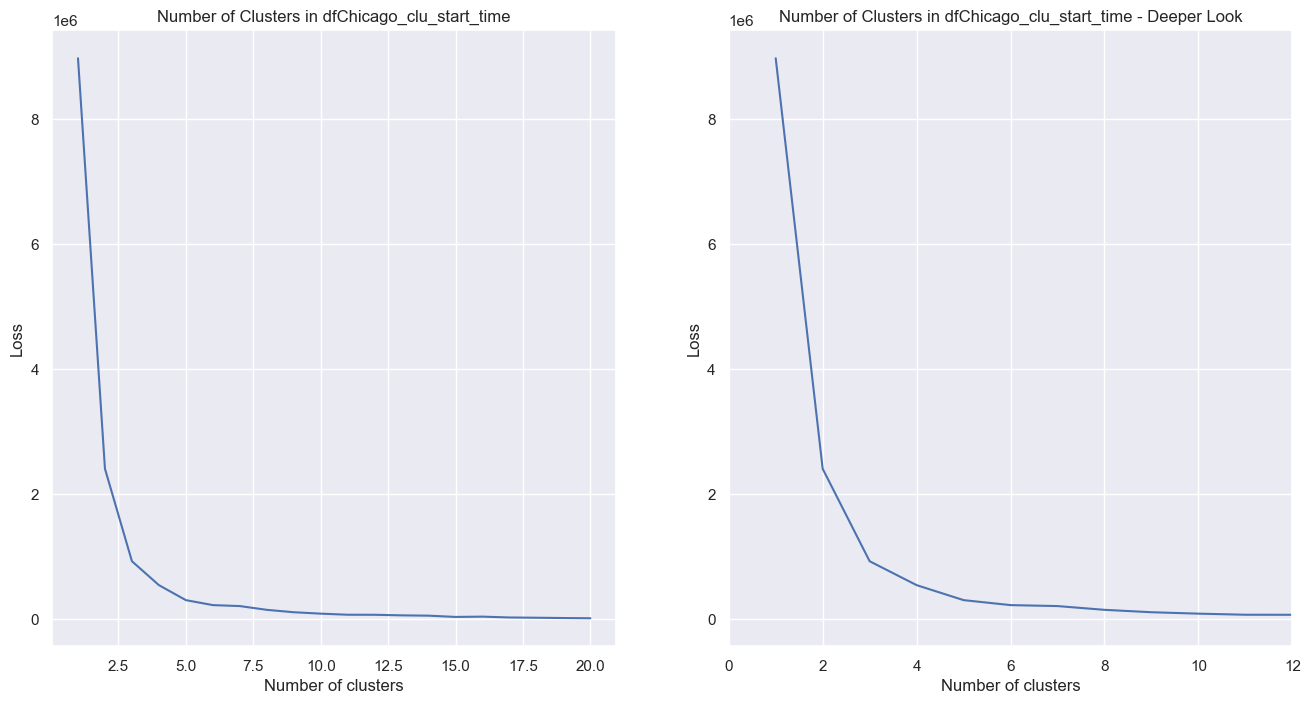

In [27]:
plot_best_fitting_number_of_clusters(dfChicago_clu_start_time_scaled, "in dfChicago_clu_start_time")

### 1.1.3 Computing Clusters with KMeans

In [28]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_start_time_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [29]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_start_time_scaled)

In [30]:
# creating a column for the calculated clusters

dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_start_time

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1040107666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time.loc[:, 'cluster_number'] = Clusters


,start_time_hourly,cluster_number
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
8974515,23,0
8974516,23,0
8974517,23,0
8974518,23,0


### 1.1.4 Analyzing Clusters & Labeling them

In [31]:
dfChicago_clu_start_time[dfChicago_clu_start_time['cluster_number']==0]['cluster_number'].count()

4195483

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


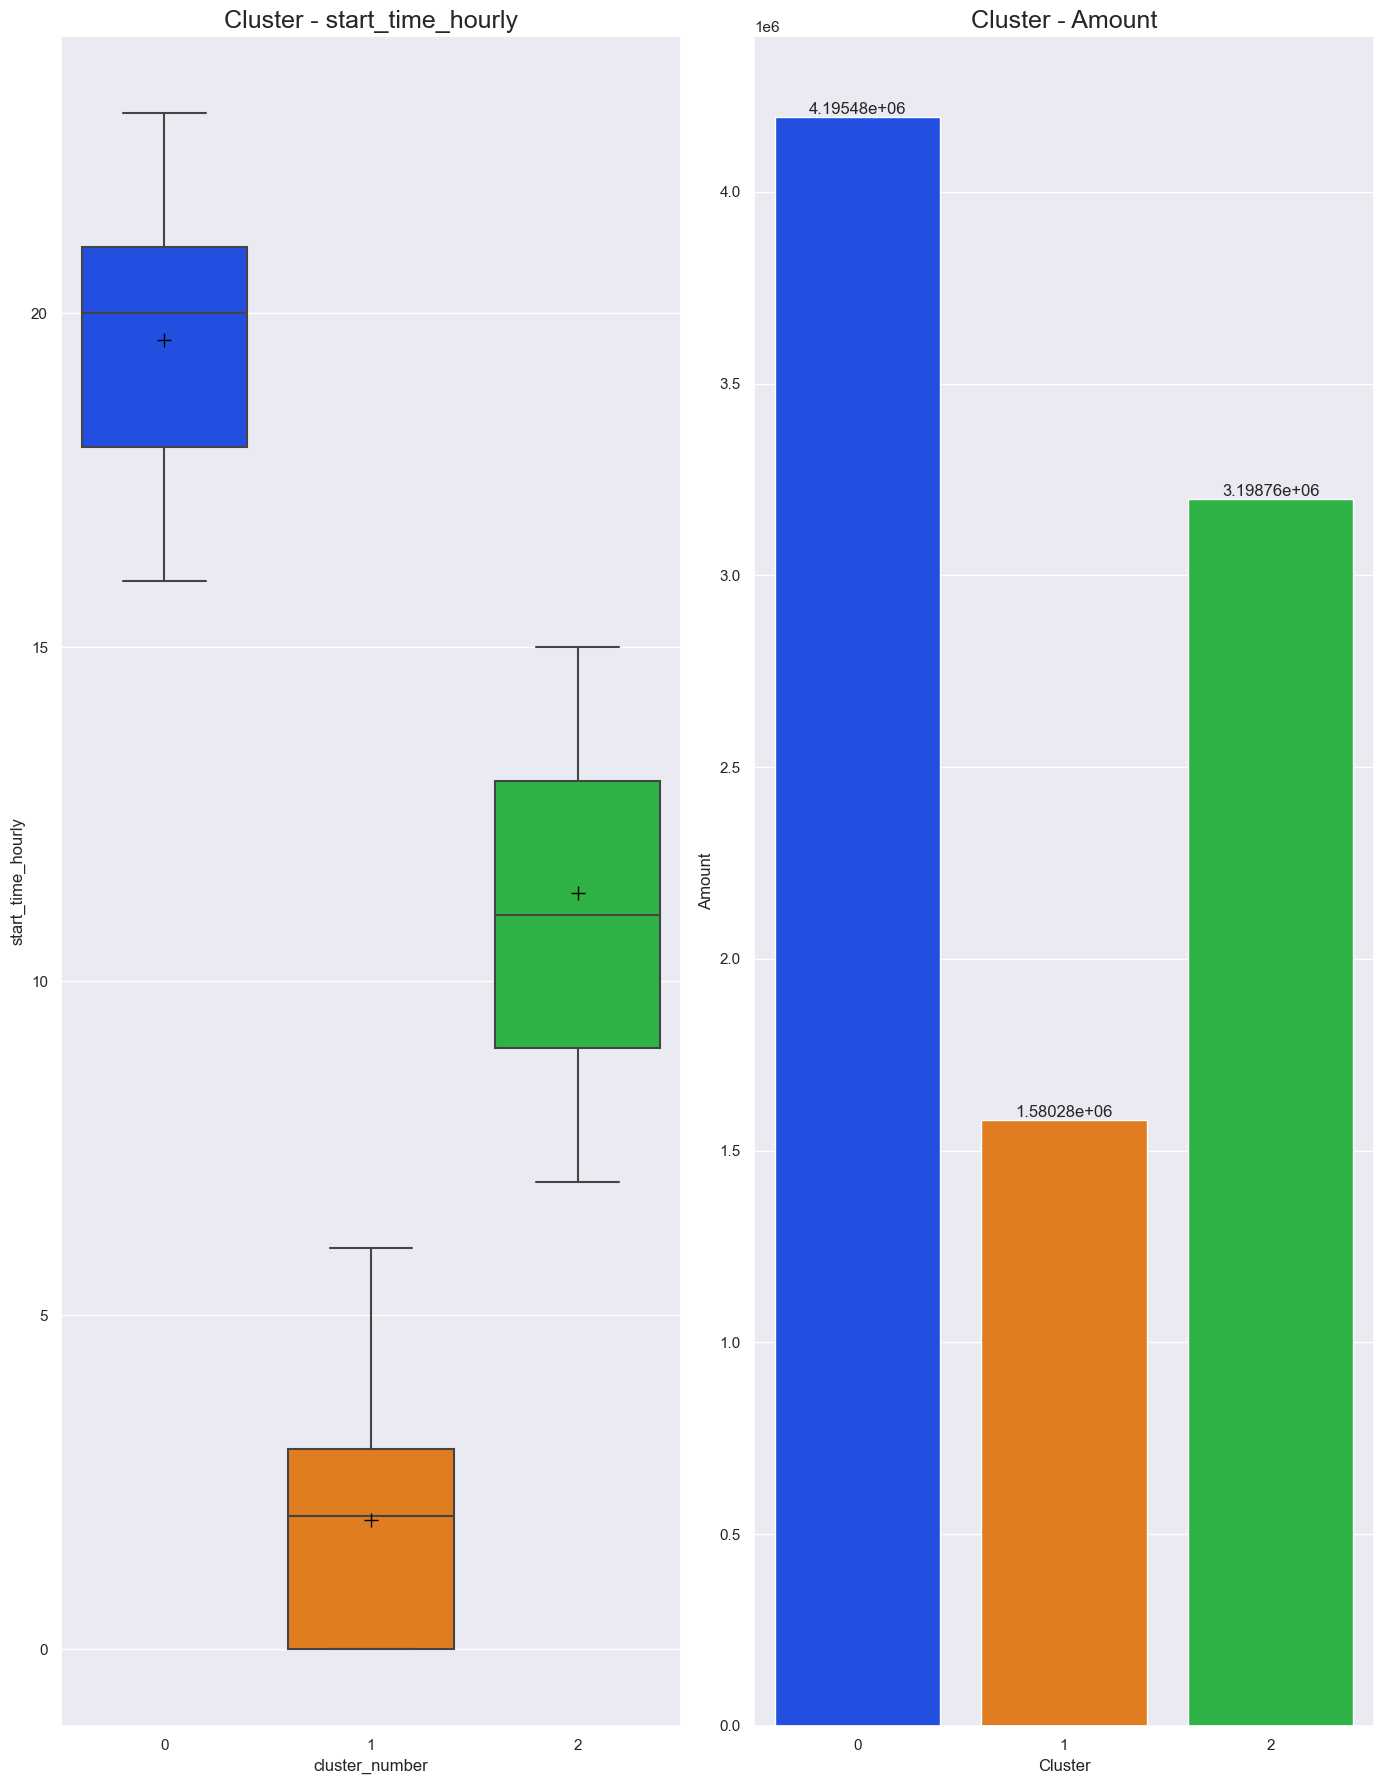

In [32]:
plot_information_about_clusters(dfChicago_clu_start_time, ['start_time_hourly'], 'cluster_number')

In [33]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(dfChicago_clu_start_time, 3, 'cluster_number')
dfChicago_clu_start_time_quantiles.sort_values(by=['start_time_hourly'], ascending=False)

,start_time_hourly,Amount Trips in Cluster,Percentage
Cluster,,,
2,9.0 - 13.0,3198762.0,35.64
0,18.0 - 21.0,4195483.0,46.75
1,0.0 - 3.0,1580275.0,17.61


In [34]:
label_names = {'0': "Evening Commuters", 
               '1': "Night Riders - Party People",
               '2': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)
dfChicago_clu_start_time = dfChicago_clu_start_time.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\788367742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_start_time['Cluster_Label'] = dfChicago_clu_start_time['cluster_number'].astype(str)


In [35]:
dfChicago_clu_start_time_index = dfChicago_clu_start_time
dfChicago_clu_start_time_index['Trip_Index'] = dfChicago_clu_start_time_index.index
dfChicago_clu_start_time_index

,start_time_hourly,cluster_number,Cluster_Label,Trip_Index
0,0,1,Night Riders - Party People,0
1,0,1,Night Riders - Party People,1
2,0,1,Night Riders - Party People,2
3,0,1,Night Riders - Party People,3
4,0,1,Night Riders - Party People,4
...,...,...,...,...
8974515,23,0,Evening Commuters,8974515
8974516,23,0,Evening Commuters,8974516
8974517,23,0,Evening Commuters,8974517
8974518,23,0,Evening Commuters,8974518


### 1.1.5 Plotting the Clustering Results

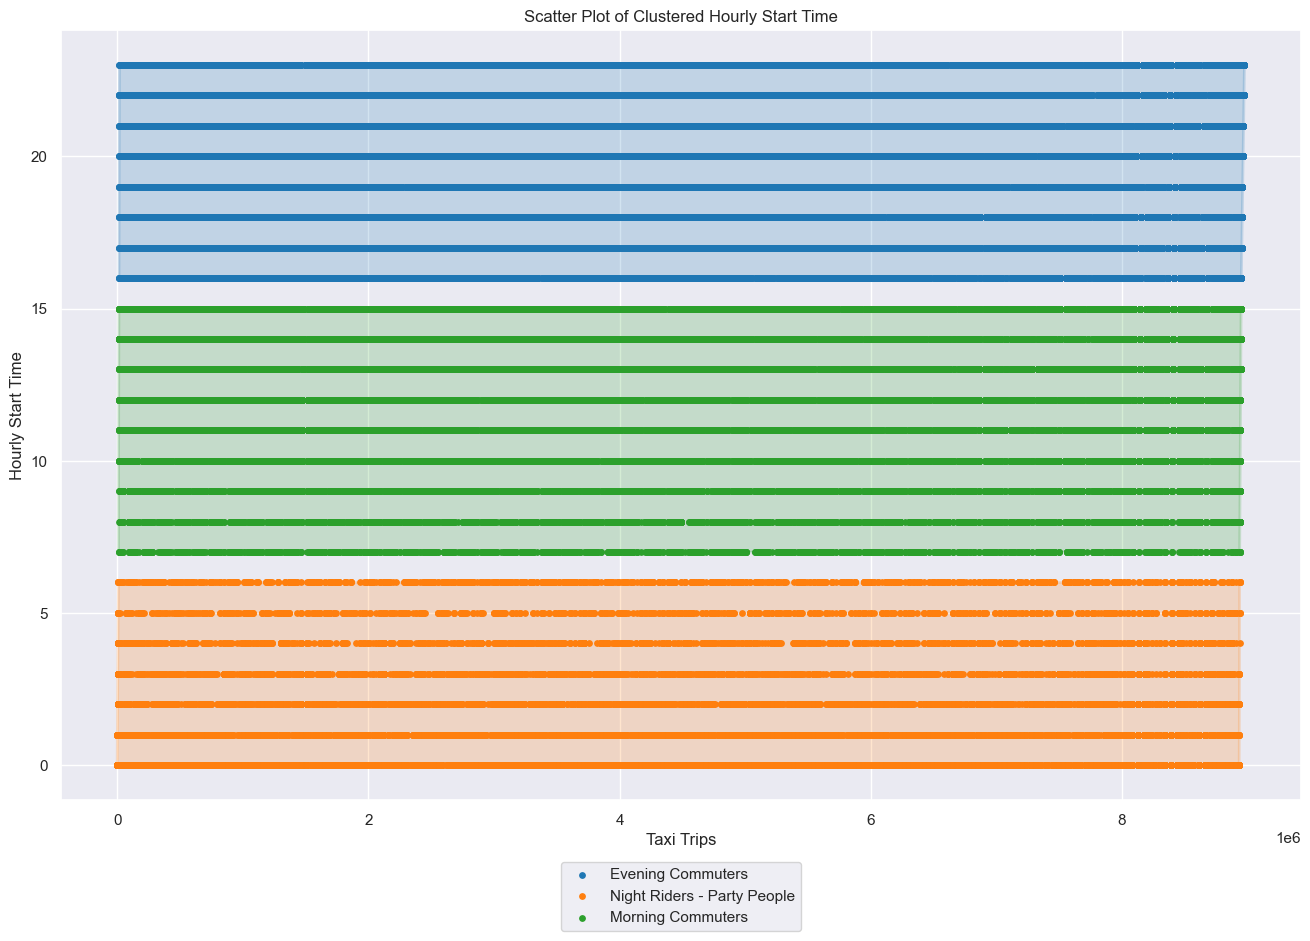

In [36]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

### 1.2.1 Feature Selection - Trip Duration

In [37]:
# Feature selection
dfChicago_clu_trip_seconds = dfChicago_clustering[['Trip_Seconds']]
dfChicago_clu_trip_seconds

,Trip_Seconds
0,900.0
1,240.0
2,1920.0
3,180.0
4,240.0
...,...
8974515,540.0
8974516,1860.0
8974517,720.0
8974518,660.0


In [38]:
# Scaling the data
dfChicago_clu_trip_seconds_scaled = scaling_data(dfChicago_clu_trip_seconds)

### 1.2.2 Validation of Number of Clusters

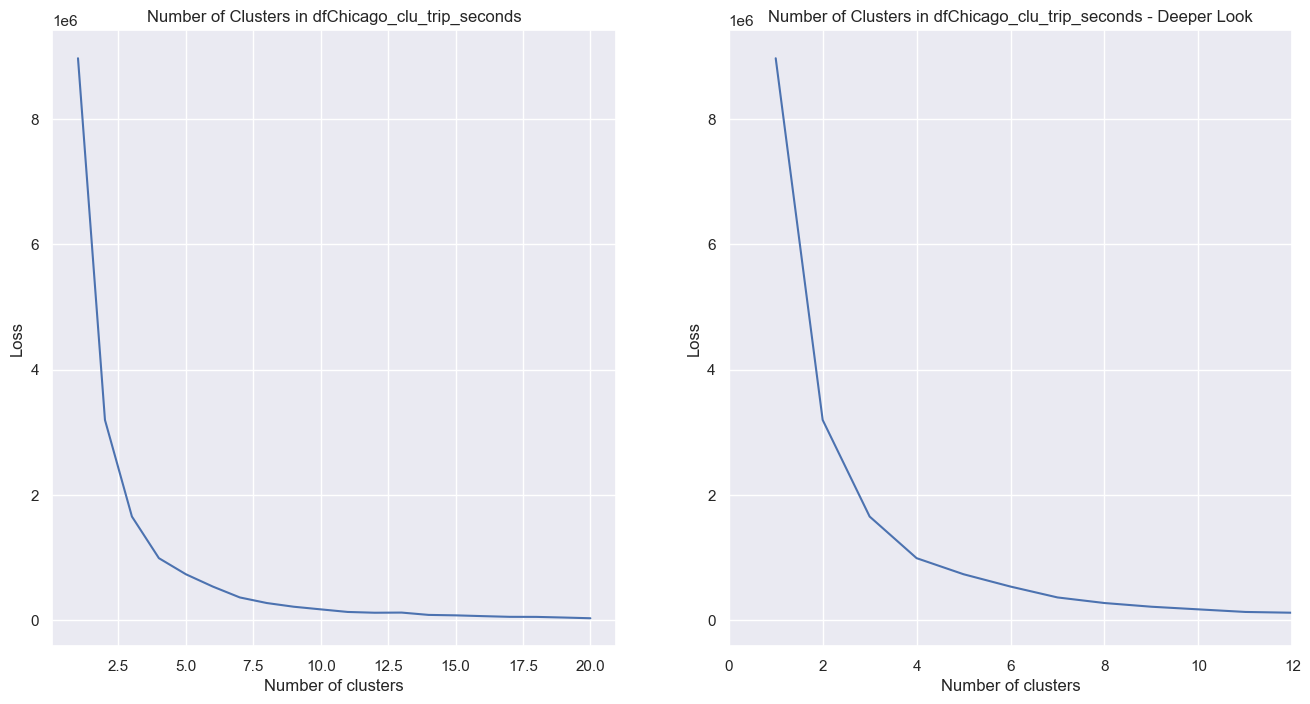

In [39]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_seconds_scaled, "in dfChicago_clu_trip_seconds")

### 1.2.3 Computing Clusters with KMeans

In [40]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_seconds_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=42)

In [41]:
# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_seconds_scaled)

In [42]:
# creating a column for the calculated clusters

dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_seconds

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\3771237839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds.loc[:, 'cluster_number'] = Clusters


,Trip_Seconds,cluster_number
0,900.0,0
1,240.0,1
2,1920.0,2
3,180.0,1
4,240.0,1
...,...,...
8974515,540.0,1
8974516,1860.0,2
8974517,720.0,0
8974518,660.0,0


### 1.2.4 Analyzing Clusters & Labeling them

In [43]:
dfChicago_clu_trip_seconds[dfChicago_clu_trip_seconds['cluster_number']==0]['cluster_number'].count()

3015335

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


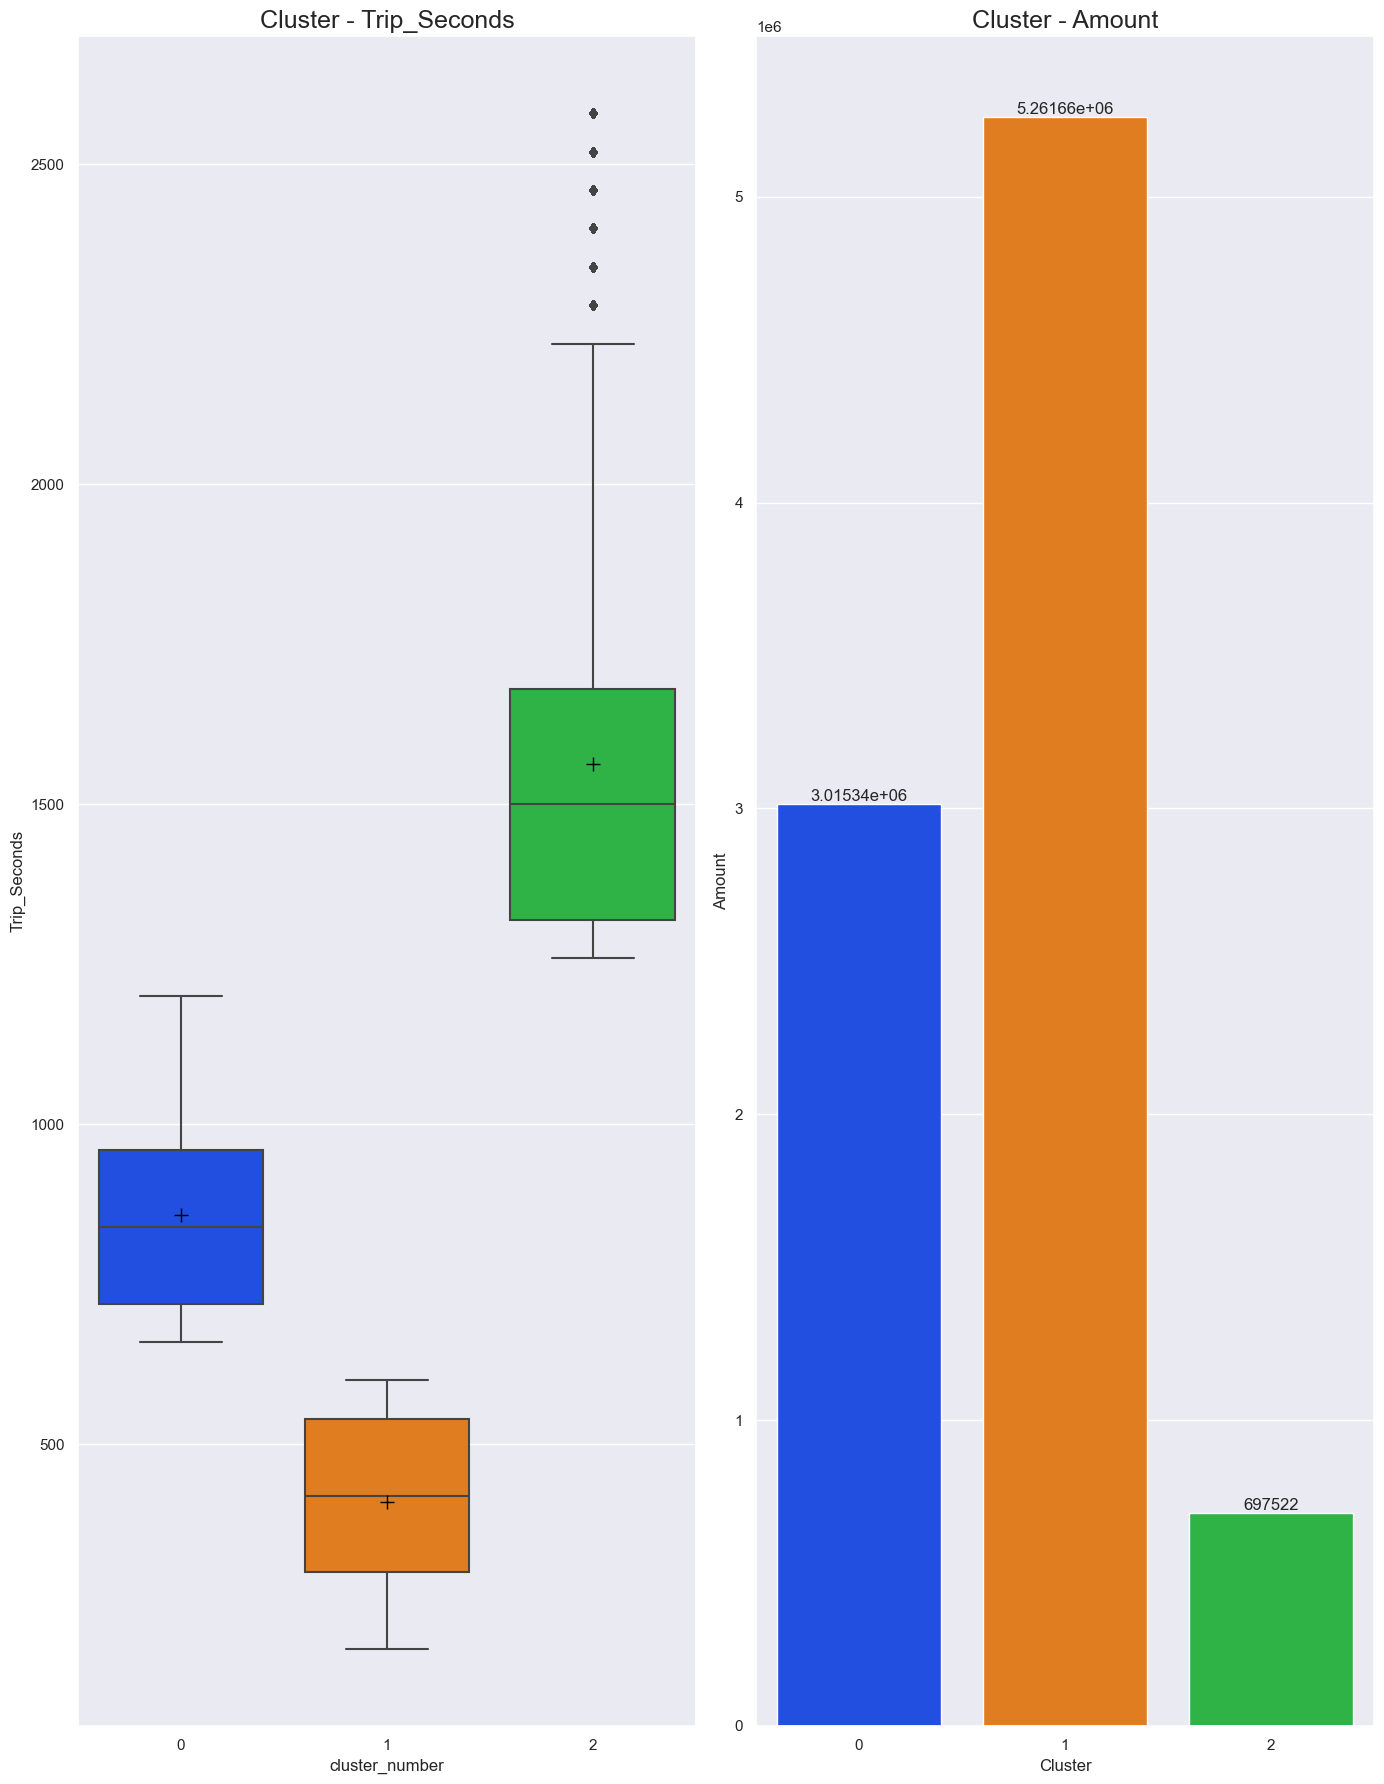

In [44]:
plot_information_about_clusters(dfChicago_clu_trip_seconds, ['Trip_Seconds'], 'cluster_number')

In [45]:
dfChicago_clu_trip_seconds_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_seconds, 3, 'cluster_number')
dfChicago_clu_trip_seconds_quantiles.sort_values(by=['Trip_Seconds'], ascending=False)


,Trip_Seconds,Amount Trips in Cluster,Percentage
Cluster,,,
0,720.0 - 960.0,3015335.0,33.60
1,300.0 - 540.0,5261663.0,58.63
2,1320.0 - 1680.0,697522.0,7.77


In [46]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)
dfChicago_clu_trip_seconds = dfChicago_clu_trip_seconds.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\662244246.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_seconds['Cluster_Label'] = dfChicago_clu_trip_seconds['cluster_number'].astype(str)


In [47]:
dfChicago_clu_trip_seconds_index = dfChicago_clu_trip_seconds
dfChicago_clu_trip_seconds_index['Trip_Index'] = dfChicago_clu_trip_seconds_index.index
dfChicago_clu_trip_seconds_index

,Trip_Seconds,cluster_number,Cluster_Label,Trip_Index
0,900.0,0,Short Trips,0
1,240.0,1,Medium Trips,1
2,1920.0,2,Long Trips,2
3,180.0,1,Medium Trips,3
4,240.0,1,Medium Trips,4
...,...,...,...,...
8974515,540.0,1,Medium Trips,8974515
8974516,1860.0,2,Long Trips,8974516
8974517,720.0,0,Short Trips,8974517
8974518,660.0,0,Short Trips,8974518


### 1.2.5 Plotting the Clustering Results

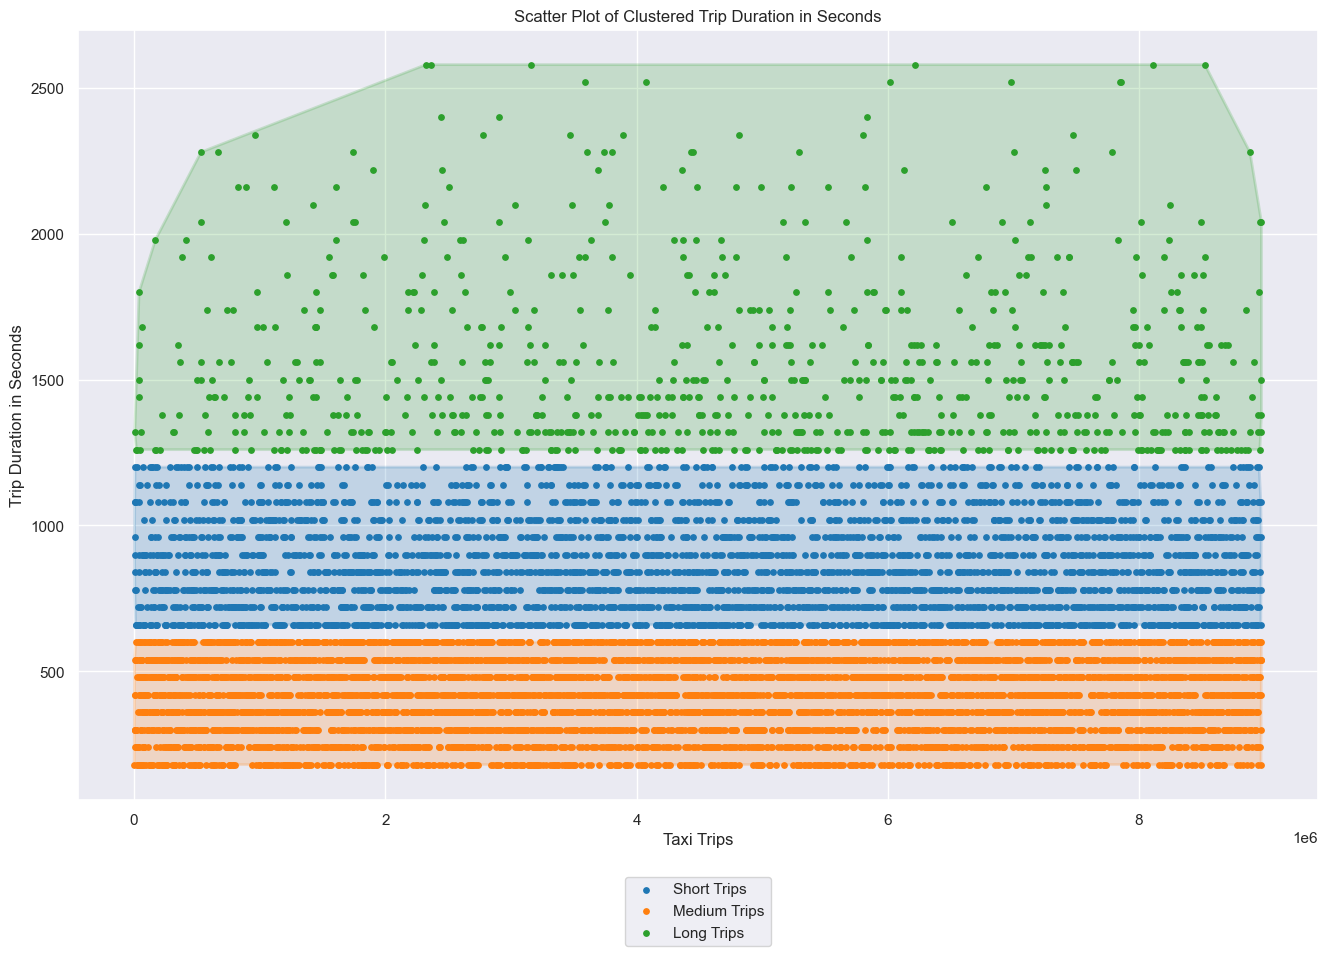

In [48]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_seconds_index.sample(n=10000), x_col='Trip_Index', y_col='Trip_Seconds', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Duration in Seconds", plot_title='Scatter Plot of Clustered Trip Duration in Seconds', leg_loc='lower center', anchor=(0.5, -0.2))

### 1.3.1 Feature Selection - Trip Length in Miles

In [49]:
# Feature selection
dfChicago_clu_trip_miles = dfChicago_clustering[['Trip_Miles']]
dfChicago_clu_trip_miles

,Trip_Miles
0,2.7
1,0.4
2,0.6
3,1.0
4,0.3
...,...
8974515,1.4
8974516,5.9
8974517,2.0
8974518,3.5


In [50]:
# Scaling the data
dfChicago_clu_trip_miles_scaled = scaling_data(dfChicago_clu_trip_miles)

### 1.3.2 Validation of Number of Clusters

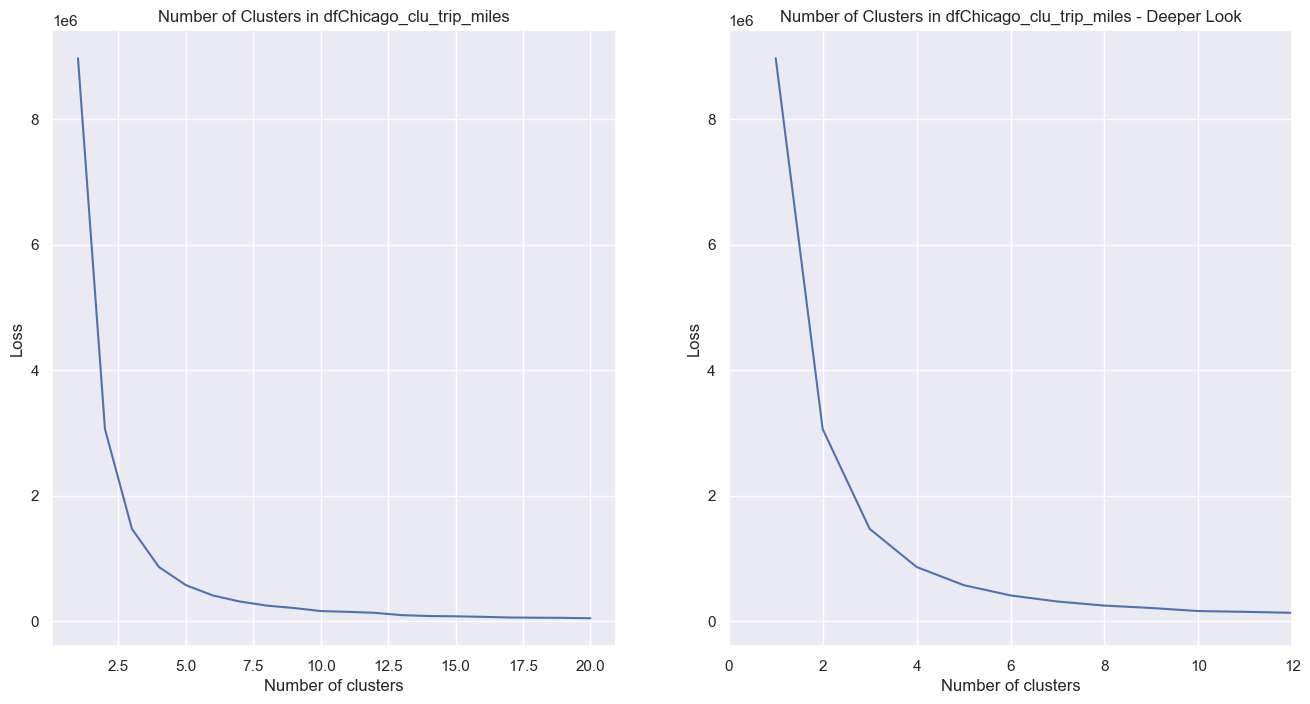

In [51]:
plot_best_fitting_number_of_clusters(dfChicago_clu_trip_miles_scaled, "in dfChicago_clu_trip_miles")

### 1.3.3 Computing Clusters with KMeans

In [52]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_trip_miles_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_trip_miles_scaled)

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
# creating a column for the calculated clusters

dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_trip_miles

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\3326964530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles.loc[:, 'cluster_number'] = Clusters


,Trip_Miles,cluster_number
0,2.7,0
1,0.4,1
2,0.6,1
3,1.0,1
4,0.3,1
...,...,...
8974515,1.4,1
8974516,5.9,0
8974517,2.0,1
8974518,3.5,0


### 1.3.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


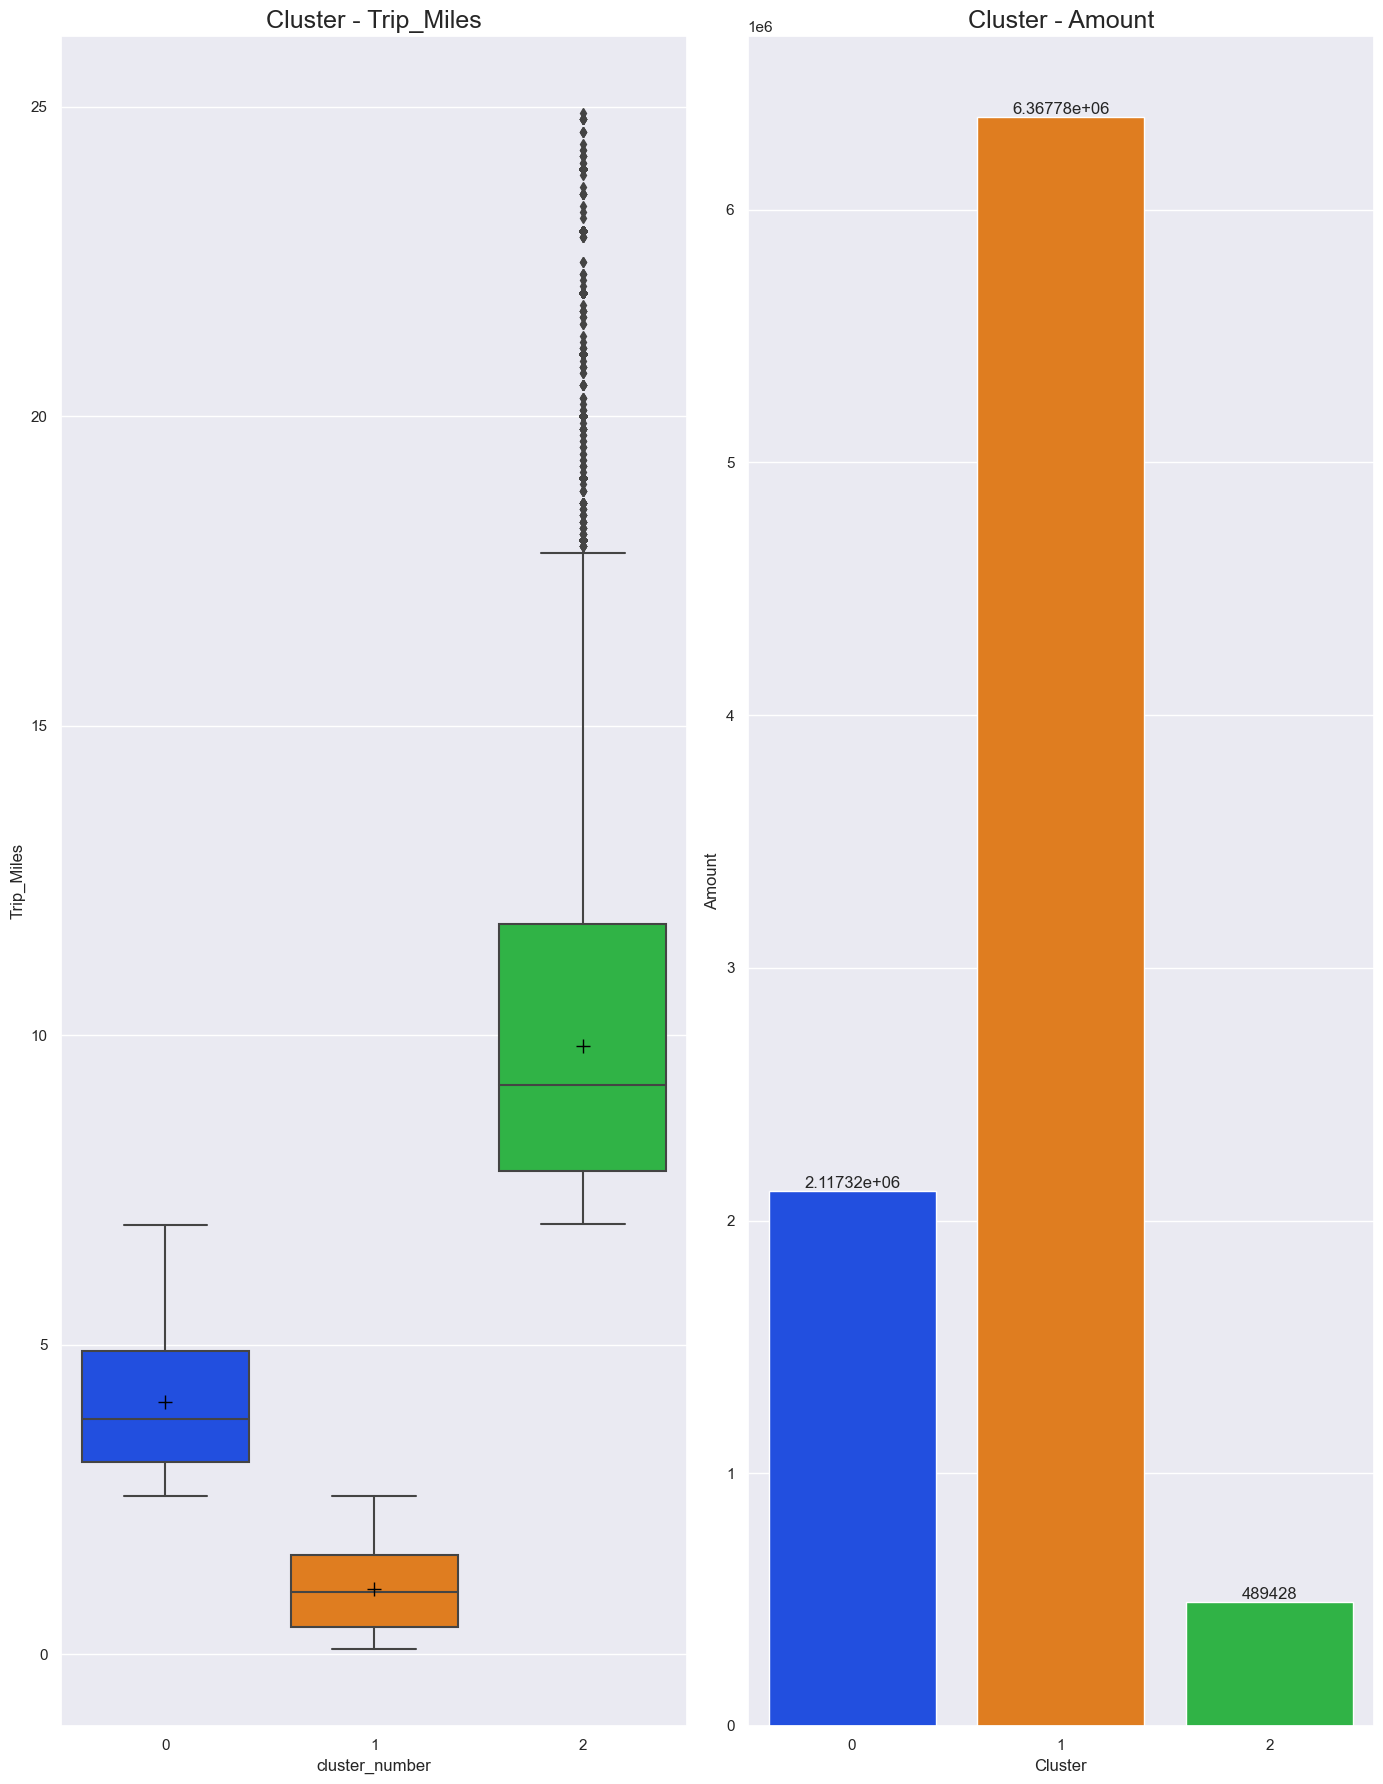

In [54]:
plot_information_about_clusters(dfChicago_clu_trip_miles, ['Trip_Miles'], 'cluster_number')

In [55]:
dfChicago_clu_trip_miles_quantiles = get_quantiles_of_clusters(dfChicago_clu_trip_miles, 3, 'cluster_number')
dfChicago_clu_trip_miles_quantiles.sort_values(by=['Trip_Miles'], ascending=False)

,Trip_Miles,Amount Trips in Cluster,Percentage
Cluster,,,
2,7.8 - 11.8,489428.0,5.45
0,3.1 - 4.9,2117317.0,23.59
1,0.44 - 1.6,6367775.0,70.95


In [56]:
label_names = {'0': "Short Trips", 
               '1': "Medium Trips",
               '2': "Long Trips"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)
dfChicago_clu_trip_miles = dfChicago_clu_trip_miles.replace({"Cluster_Label": label_names})

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\2306004952.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_trip_miles['Cluster_Label'] = dfChicago_clu_trip_miles['cluster_number'].astype(str)


In [57]:
dfChicago_clu_trip_miles_index = dfChicago_clu_trip_miles
dfChicago_clu_trip_miles_index['Trip_Index'] = dfChicago_clu_trip_miles_index.index
dfChicago_clu_trip_miles_index

,Trip_Miles,cluster_number,Cluster_Label,Trip_Index
0,2.7,0,Short Trips,0
1,0.4,1,Medium Trips,1
2,0.6,1,Medium Trips,2
3,1.0,1,Medium Trips,3
4,0.3,1,Medium Trips,4
...,...,...,...,...
8974515,1.4,1,Medium Trips,8974515
8974516,5.9,0,Short Trips,8974516
8974517,2.0,1,Medium Trips,8974517
8974518,3.5,0,Short Trips,8974518


### 1.3.5 Plotting the Clustering Results

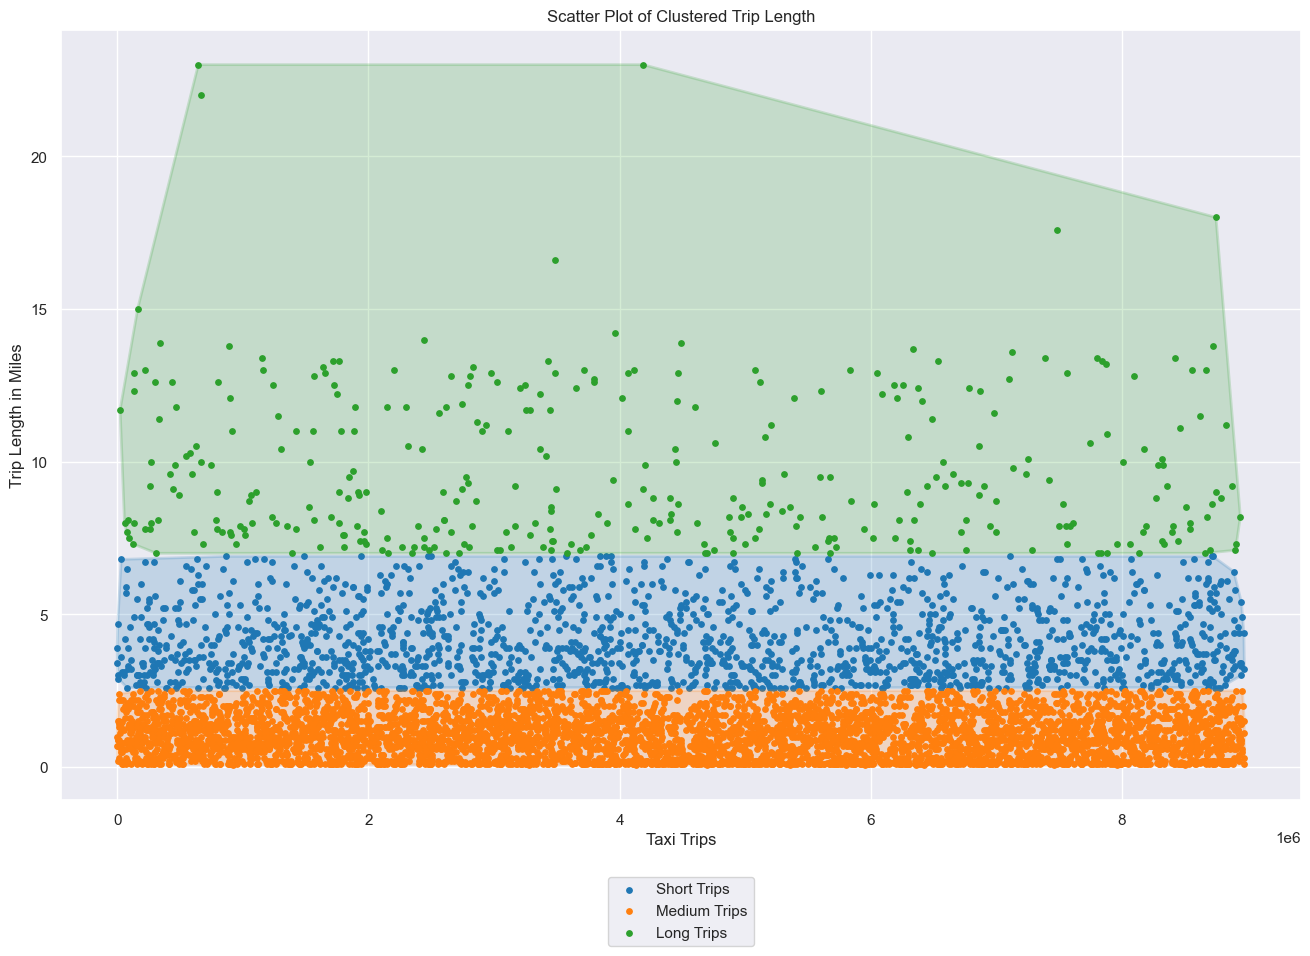

In [58]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_trip_miles_index.sample(n=7000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.2))

### 1.4.1 Feature Selection - Combining Start Time, Trip Duration & Trip Length


In [59]:
# Feature selection
dfChicago_clu_combined = dfChicago_clustering[['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles']]
dfChicago_clu_combined

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


In [60]:
# Scaling the data
dfChicago_clu_combined_scaled = scaling_data(dfChicago_clu_combined)

### 1.4.2 Validation of Number of Clusters

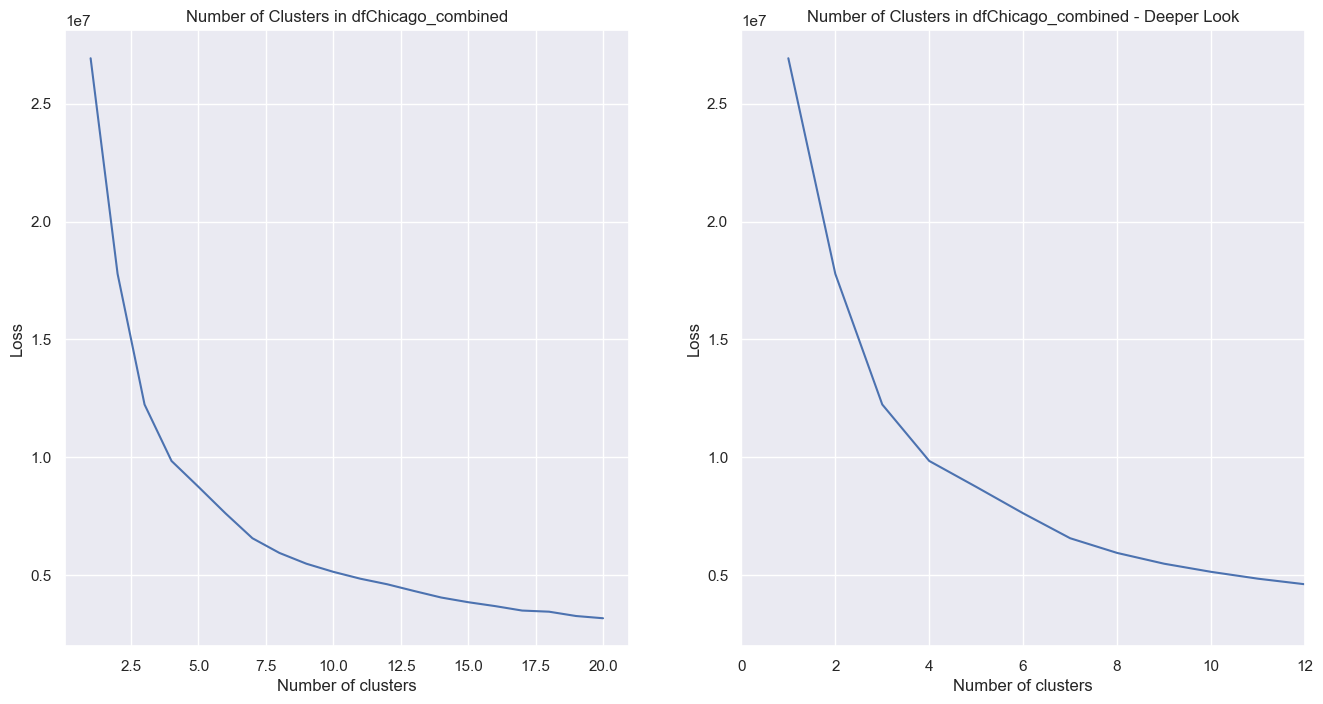

In [61]:
plot_best_fitting_number_of_clusters(dfChicago_clu_combined_scaled, "in dfChicago_combined")

### 1.4.3 Computing Clusters with KMeans

In [62]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=4,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_combined_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_combined_scaled)

# creating a column for the calculated clusters

dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_combined

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1325623314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined.loc[:, 'cluster_number'] = Clusters


,start_time_hourly,Trip_Seconds,Trip_Miles,cluster_number
0,0,900.0,2.7,0
1,0,240.0,0.4,0
2,0,1920.0,0.6,3
3,0,180.0,1.0,0
4,0,240.0,0.3,0
...,...,...,...,...
8974515,23,540.0,1.4,1
8974516,23,1860.0,5.9,2
8974517,23,720.0,2.0,1
8974518,23,660.0,3.5,3


### 1.4.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


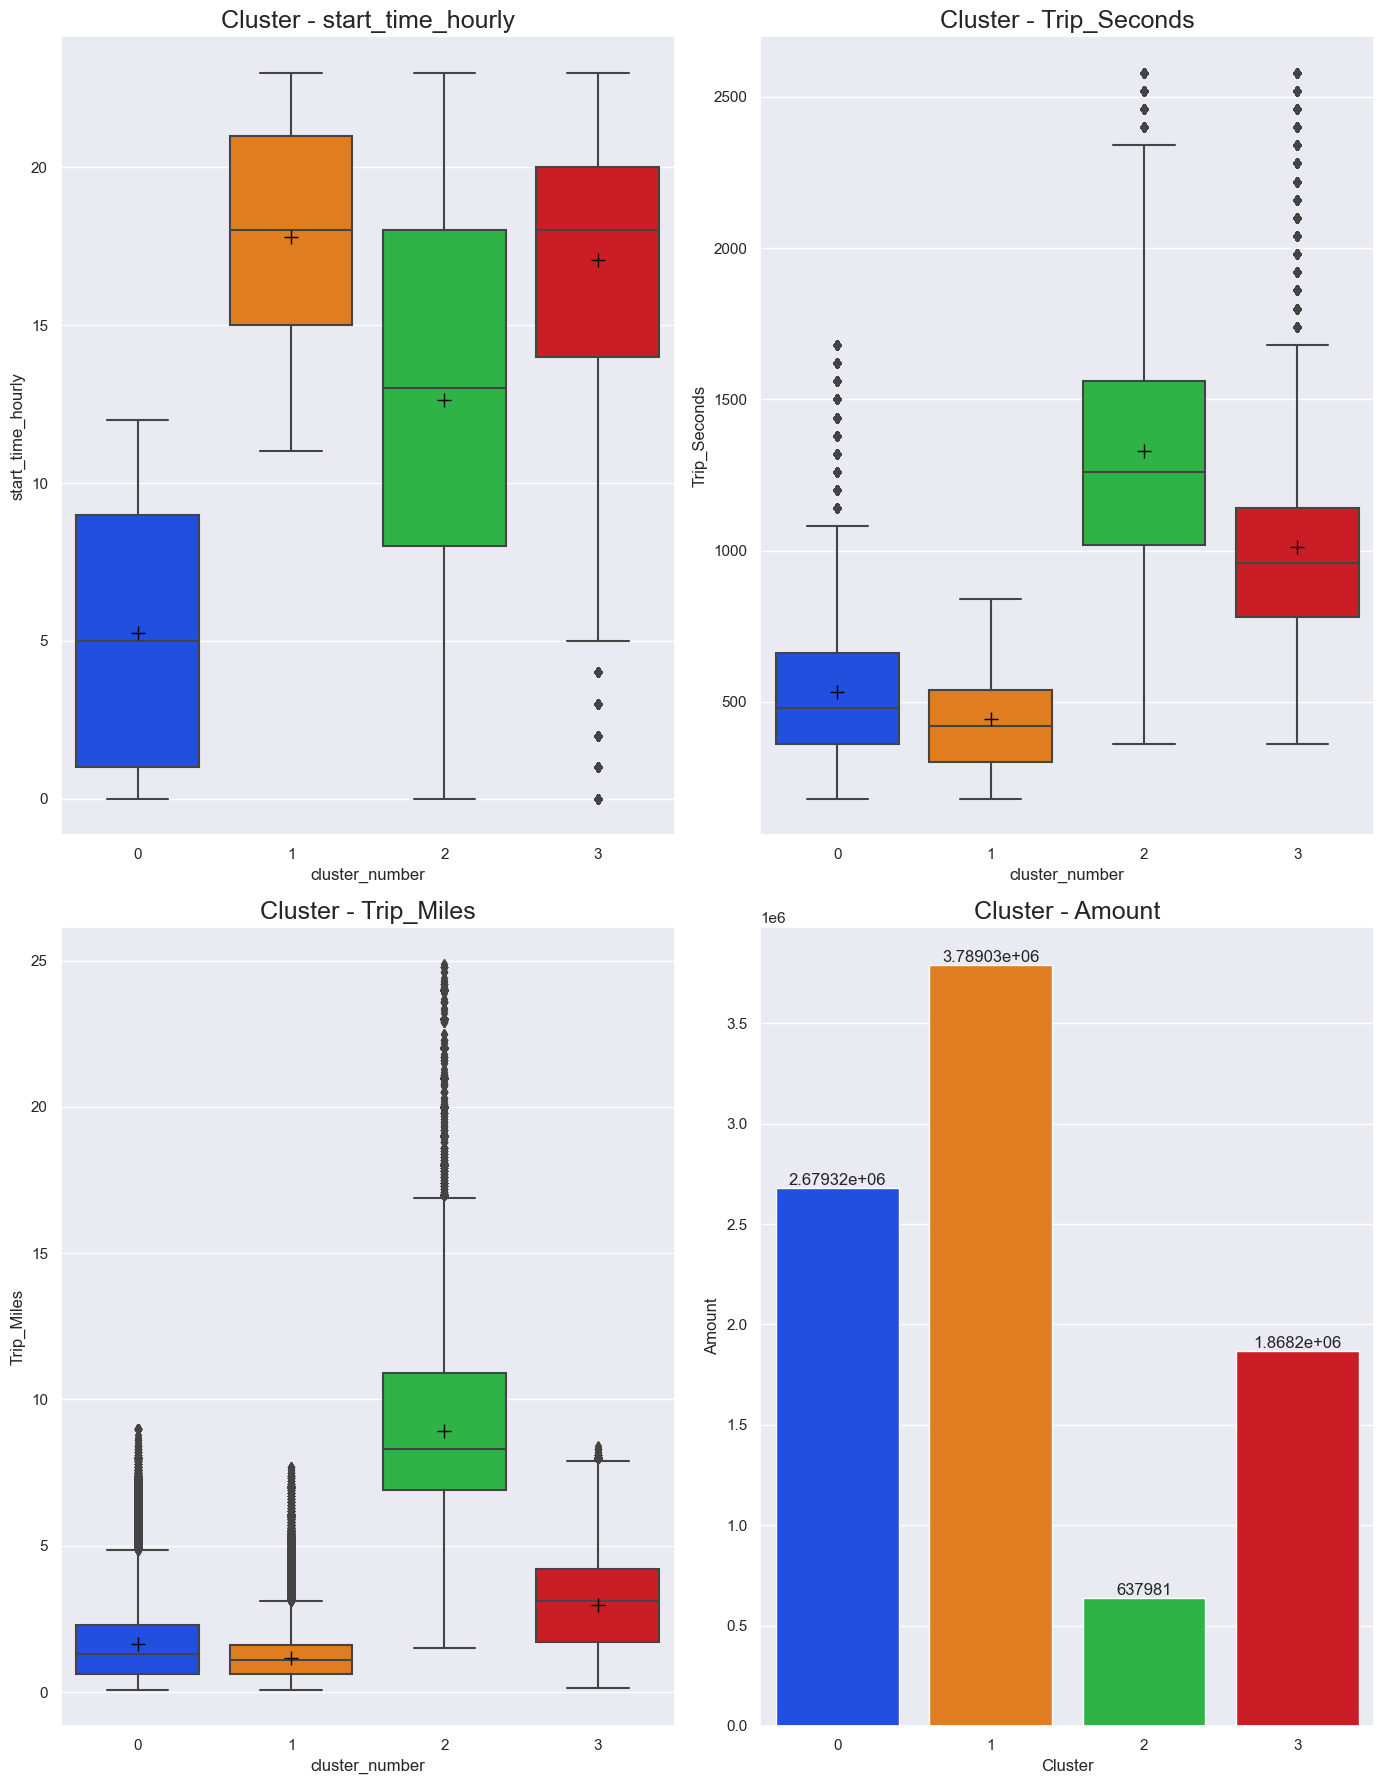

In [63]:
plot_information_about_clusters(dfChicago_clu_combined, ['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles'], 'cluster_number')

In [64]:
dfChicago_clu_combined_quantiles = get_quantiles_of_clusters(dfChicago_clu_combined, 4, 'cluster_number')
dfChicago_clu_combined_quantiles.sort_values(by=['start_time_hourly', 'Trip_Seconds'], ascending=False)

,start_time_hourly,Trip_Seconds,Trip_Miles,Amount Trips in Cluster,Percentage
Cluster,,,,,
2,8.0 - 18.0,1020.0 - 1560.0,6.9 - 10.9,637981.0,7.11
1,15.0 - 21.0,300.0 - 540.0,0.6 - 1.6,3789027.0,42.22
3,14.0 - 20.0,780.0 - 1140.0,1.7 - 4.2,1868196.0,20.82
0,1.0 - 9.0,360.0 - 660.0,0.6 - 2.3,2679316.0,29.85


In [65]:
label_names = {'0': "Evening Commuters", 
               '1': "Short to Medium Rides (2 - 4 Miles)",
               '2': "Long Rides (7 - 11 miles)",
               '3': "Party People / Night Riders",
               '4': "Morning Commuters"}

# integrating our labeled clusters in the dataframe
dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)
dfChicago_clu_combined = dfChicago_clu_combined.replace({"Cluster_Label": label_names})

#dfChicago_clu_combined_index = dfChicago_clu_combined
#dfChicago_clu_combined_index['Trip_Index'] = dfChicago_clu_combined_index.index
#dfChicago_clu_combined_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\626434873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_combined['Cluster_Label'] = dfChicago_clu_combined['cluster_number'].astype(str)


### 1.4.5 Plotting the Clustering Results

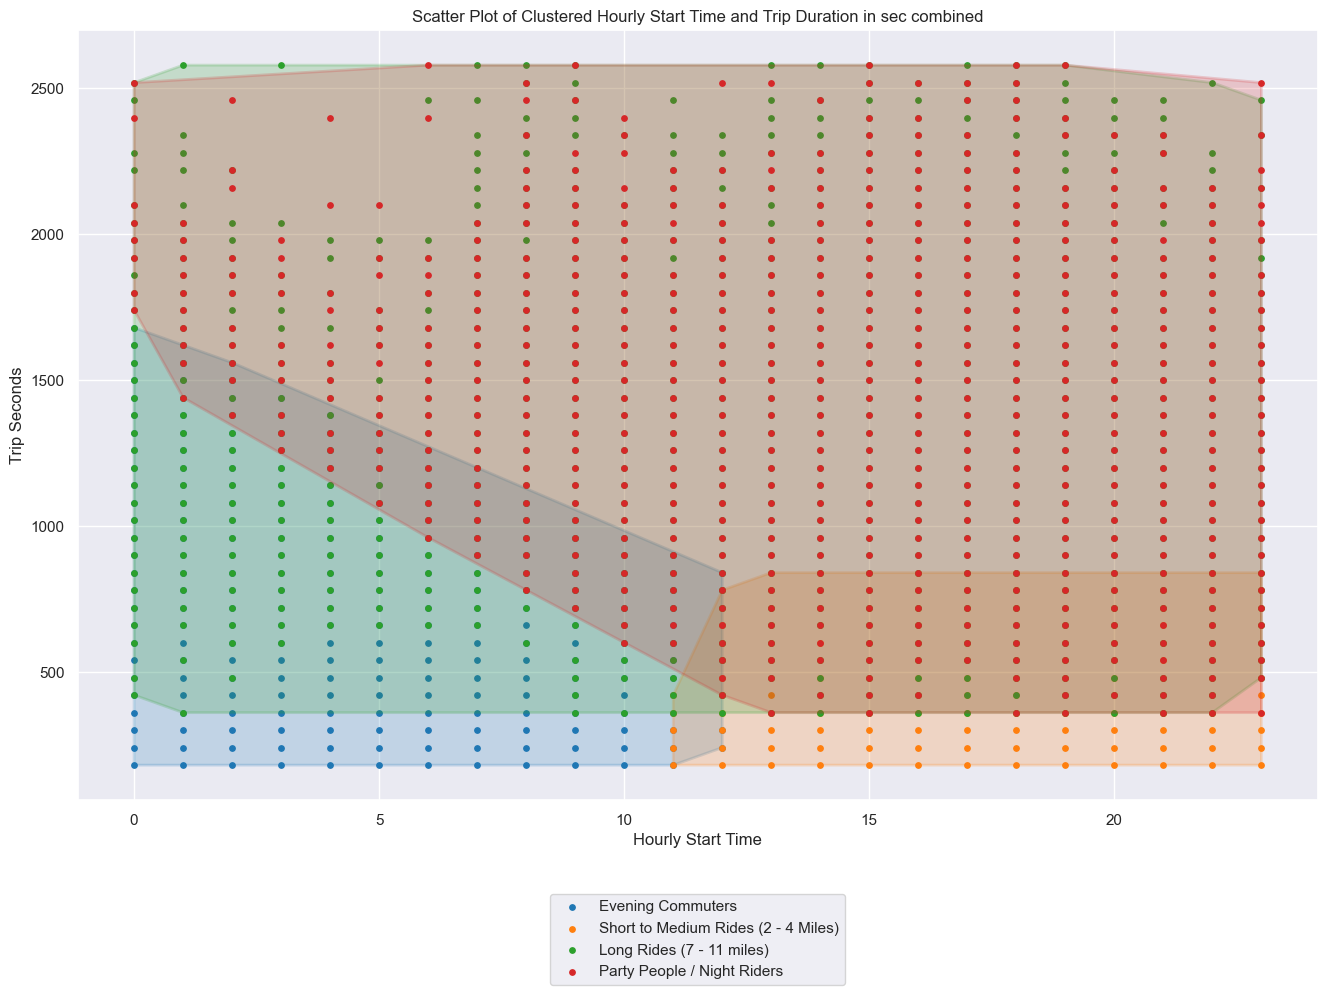

In [66]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=100_000), x_col='start_time_hourly', y_col='Trip_Seconds', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Seconds", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in sec combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

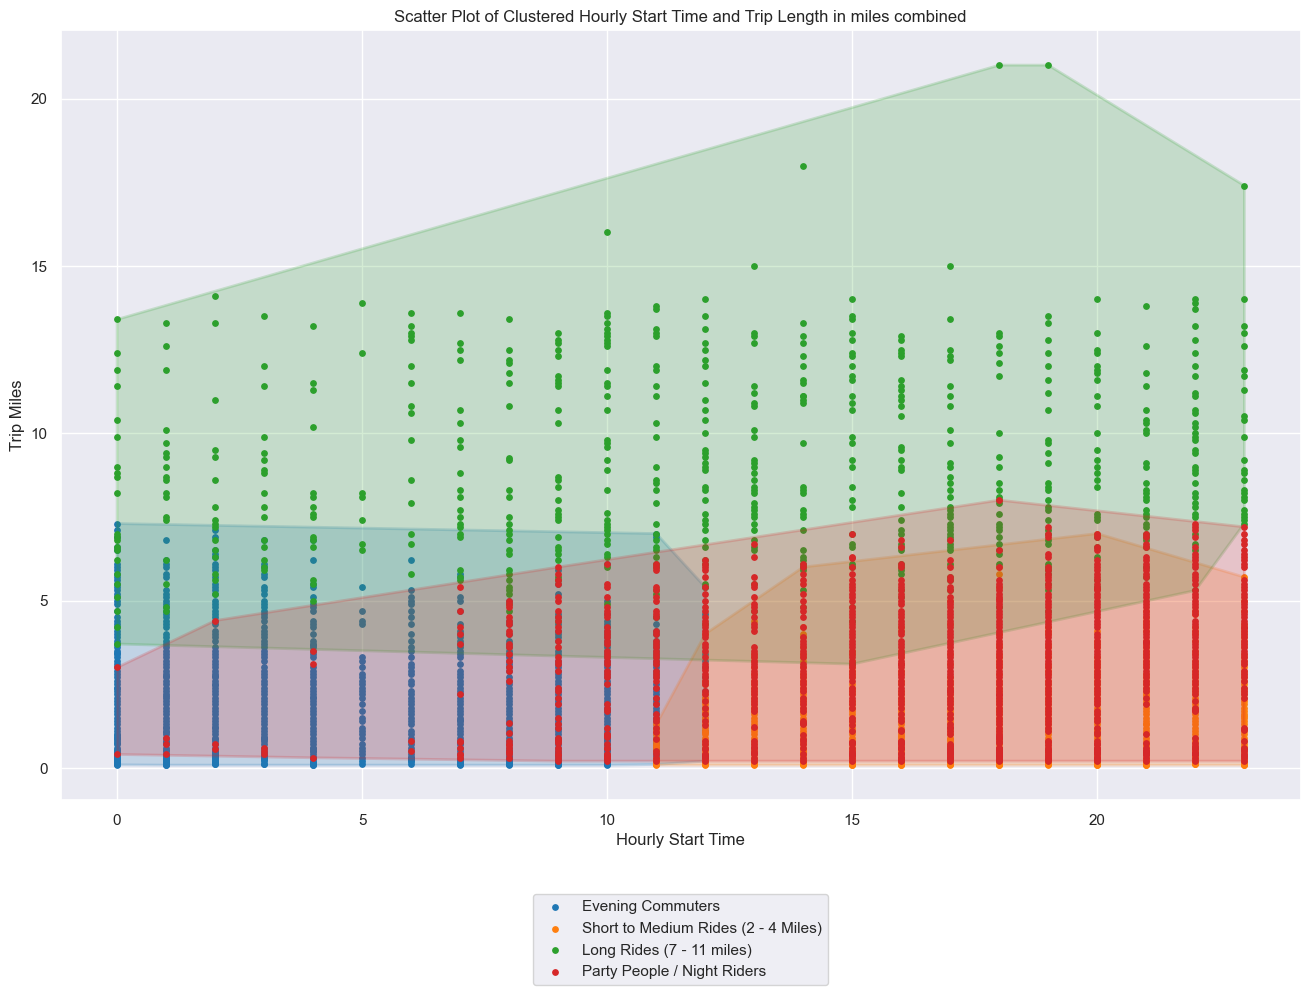

In [67]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Length in miles combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

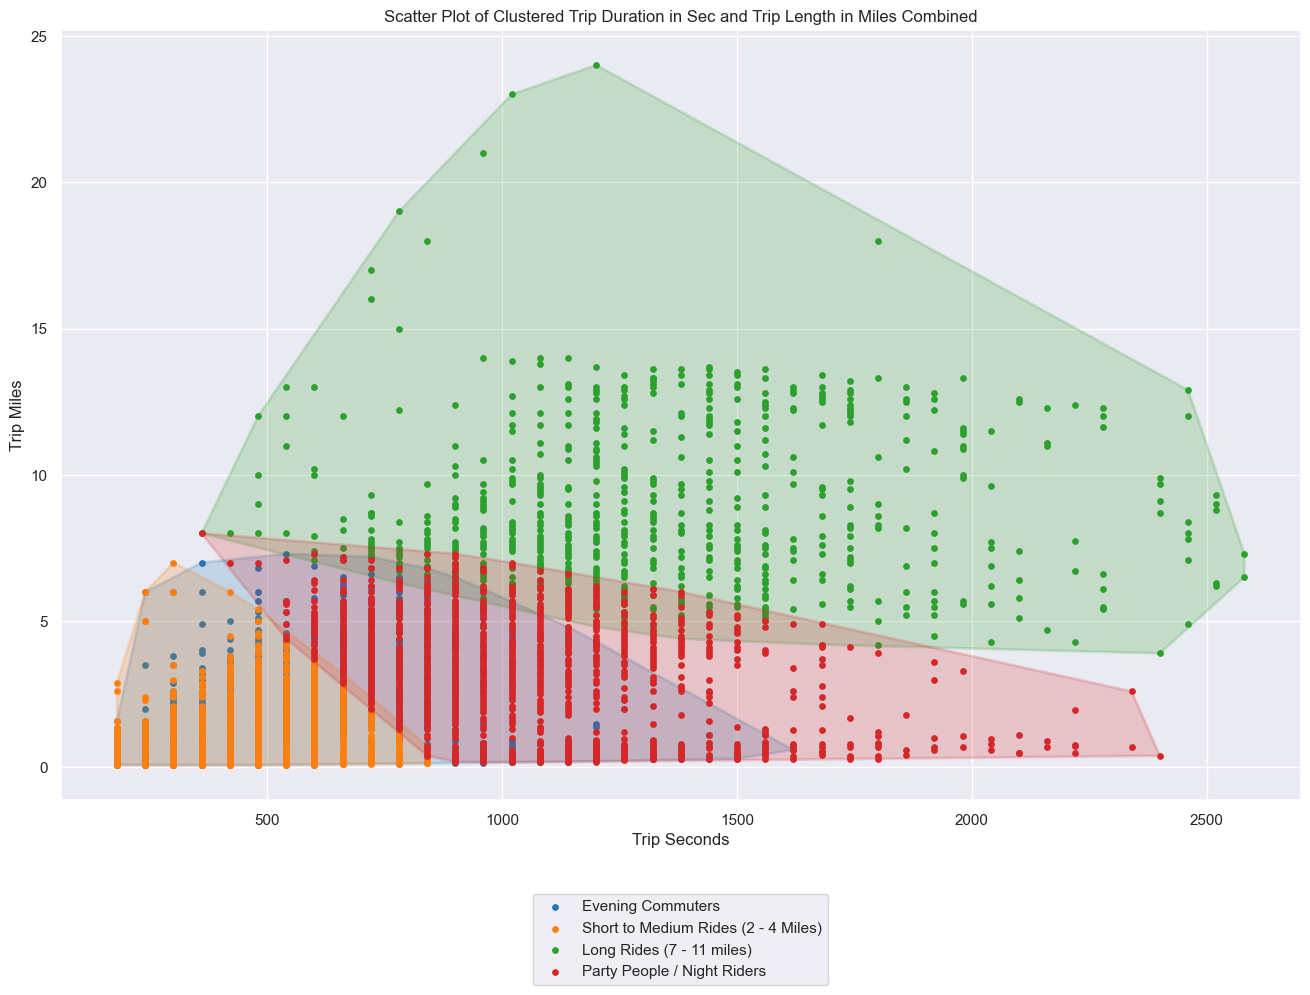

In [68]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_combined.sample(n=10_000), x_col='Trip_Seconds', y_col='Trip_Miles', cluster_col='cluster_number', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Seconds', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Duration in Sec and Trip Length in Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


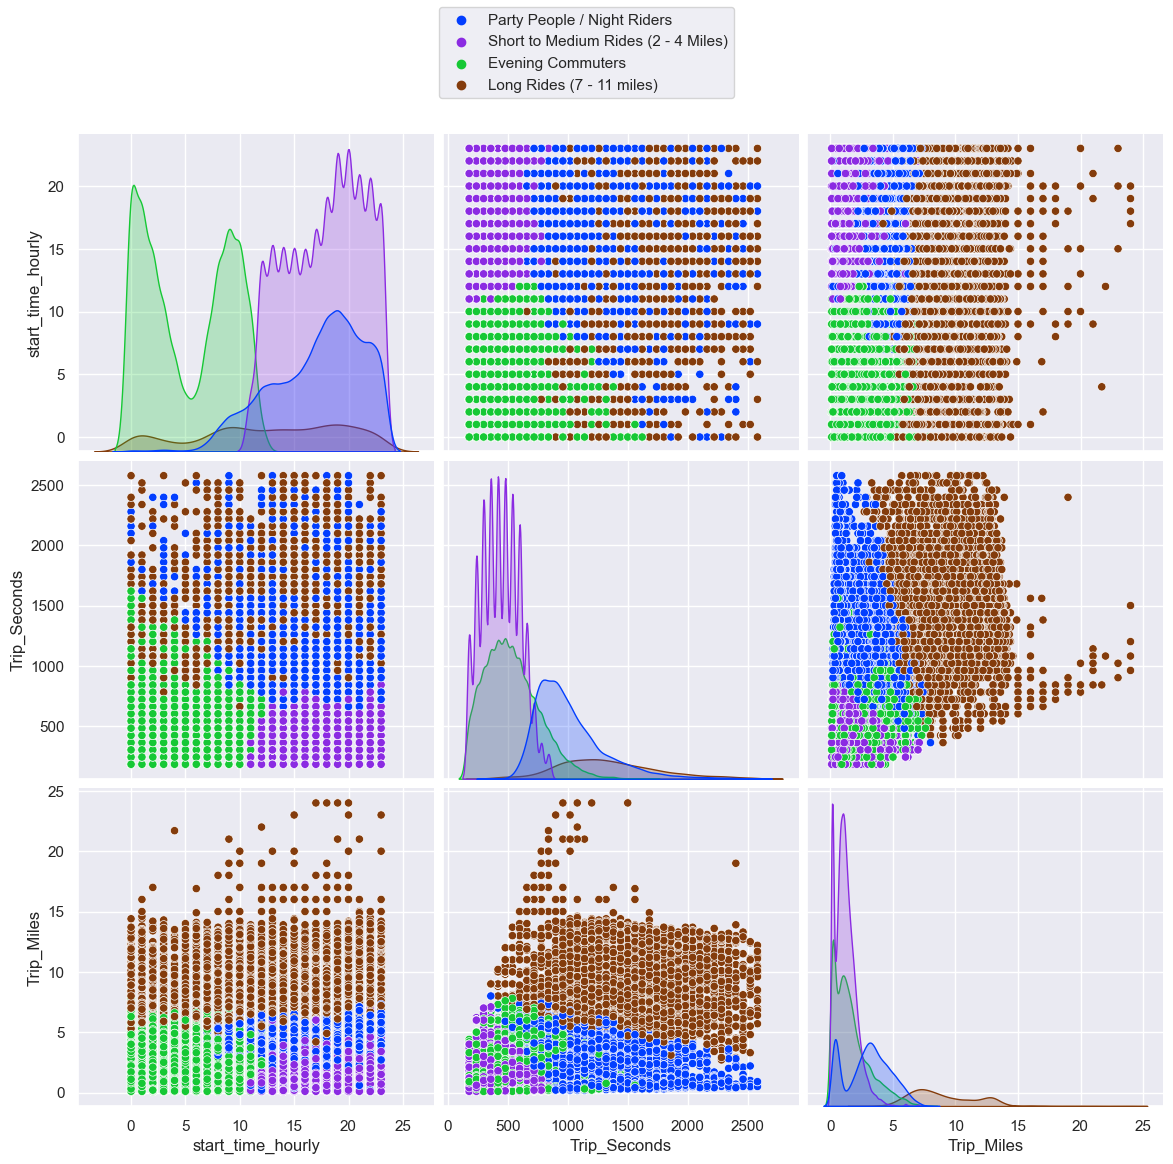

In [69]:
colors = {'Evening Commuters' : '#16C835',
          'Morning Commuters' : '#FF7C00',
          'Short to Medium Rides (2 - 4 Miles)' : '#8B2BE2',
          'Long Rides (7 - 11 miles)' : '#843C0C',
          'Party People / Night Riders': '#023EFF'}

g = sns.pairplot(data=dfChicago_clu_combined[['start_time_hourly', 'Trip_Seconds' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

### 1.5.1 Feature Selection - Distance to City Center Pickup 

In [80]:
# Feature selection
dfChicago_clu_distance_to_city_center_pickup = dfChicago_clustering[['distance_to_city_center_pickup']]
dfChicago_clu_distance_to_city_center_pickup

,distance_to_city_center_pickup
0,1.614272
1,3.617721
2,4.476686
3,2.685629
4,0.495382
...,...
8974515,0.893287
8974516,1.401331
8974517,0.725199
8974518,1.344327


In [86]:
# Scaling the data
dfChicago_clu_distance_to_city_center_pickup_scaled = scaling_data(dfChicago_clu_distance_to_city_center_pickup)

### 1.5.2 Validation of Number of Clusters

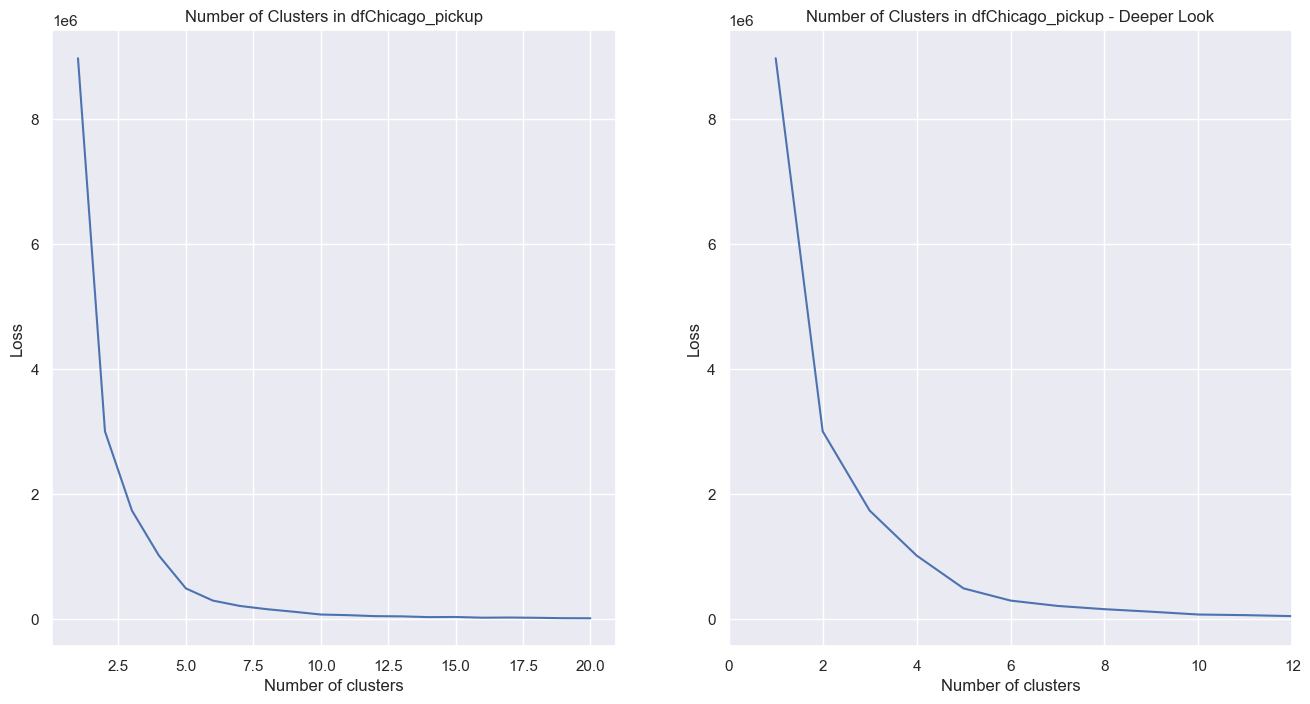

In [87]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_pickup_scaled, "in dfChicago_pickup")

### 1.5.3 Computing Clusters with KMeans

In [88]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_pickup_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_pickup_scaled)

# creating a column for the calculated clusters

dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_pickup

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\275767884.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup.loc[:, 'cluster_number'] = Clusters


,distance_to_city_center_pickup,cluster_number
0,1.614272,0
1,3.617721,1
2,4.476686,1
3,2.685629,1
4,0.495382,0
...,...,...
8974515,0.893287,0
8974516,1.401331,0
8974517,0.725199,0
8974518,1.344327,0


### 1.5.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


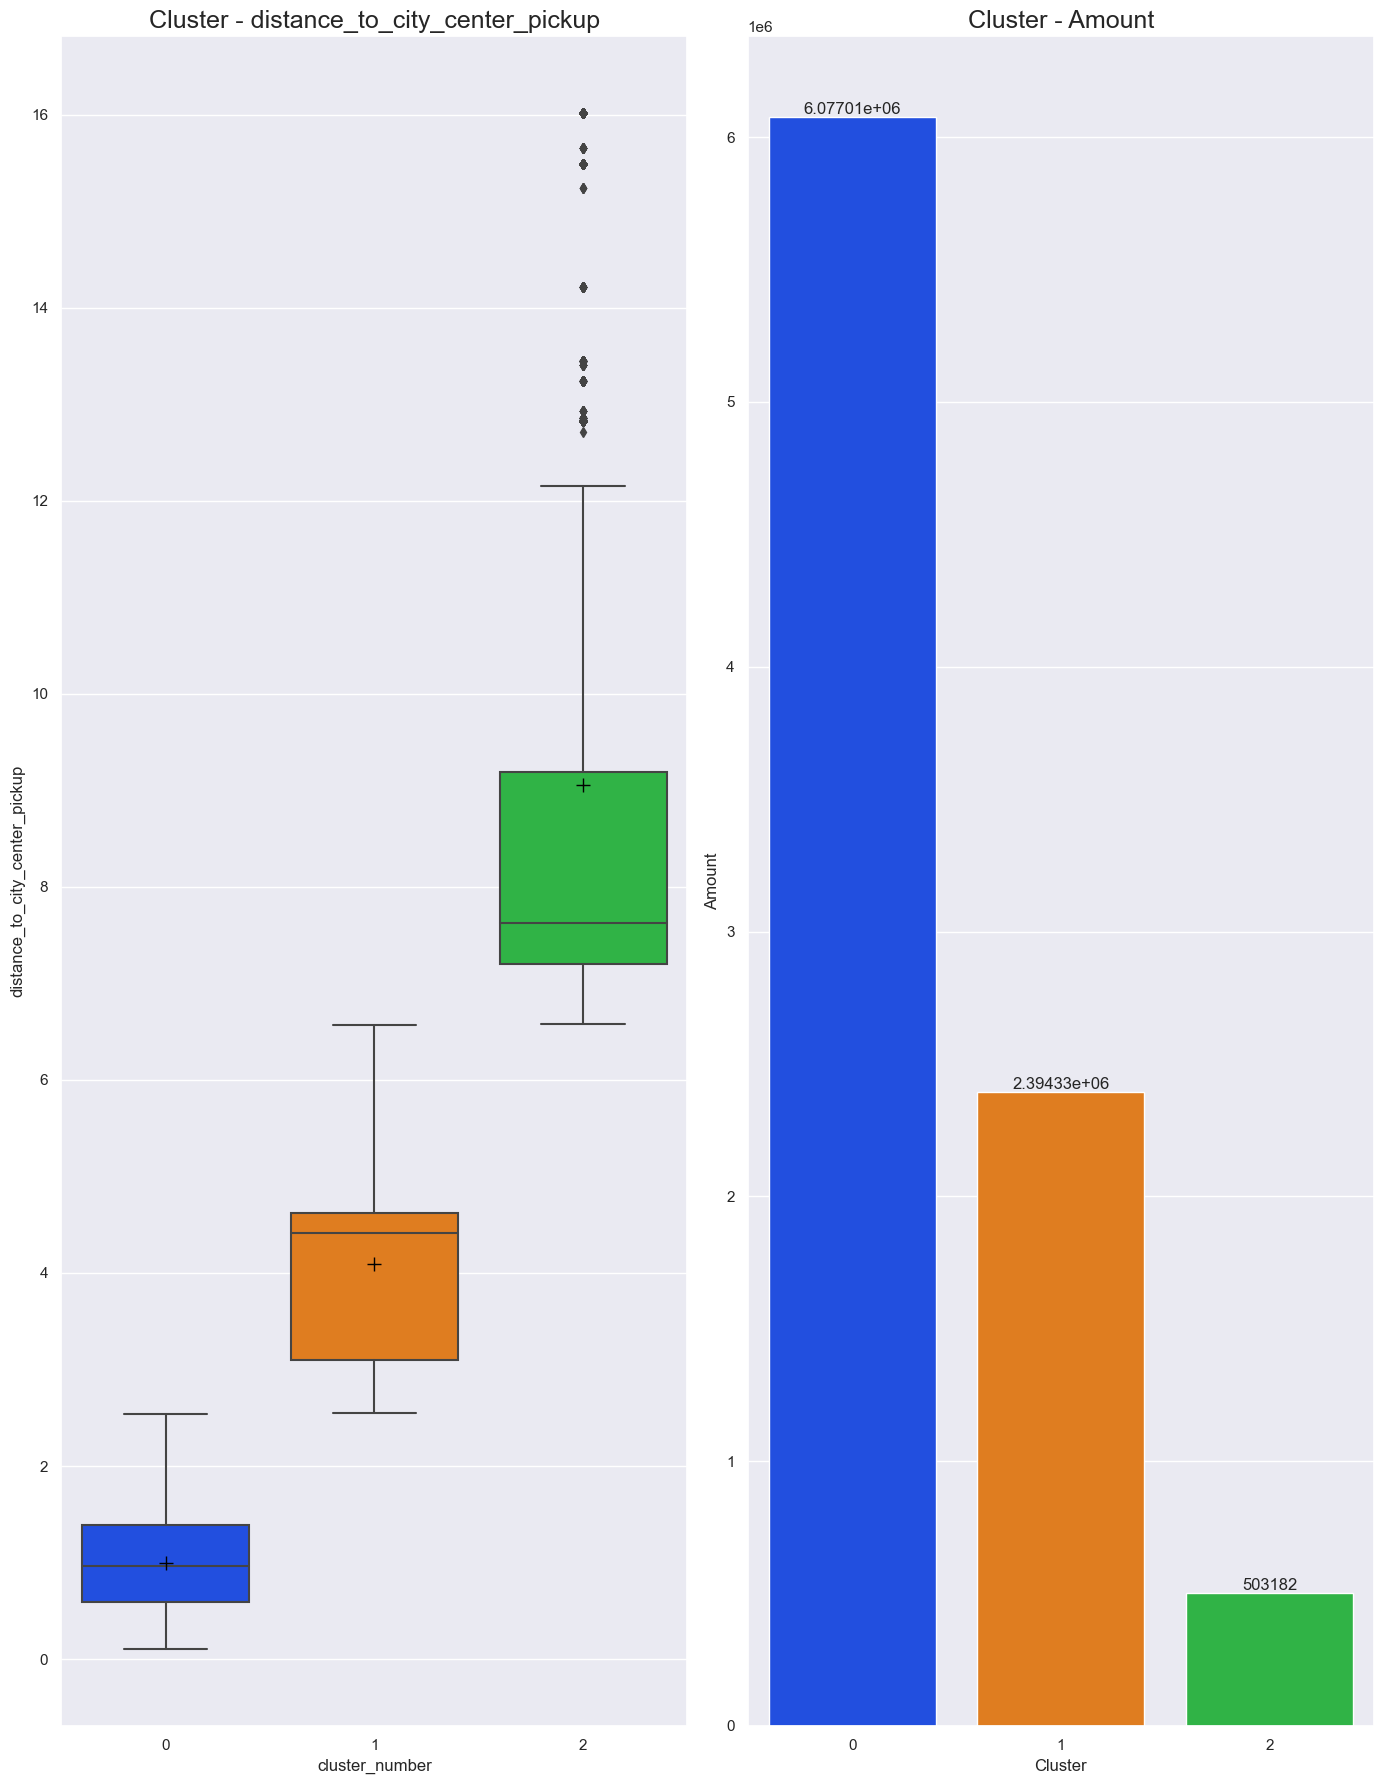

In [90]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_pickup, ['distance_to_city_center_pickup'], 'cluster_number')

In [93]:
dfChicago_clu_distance_to_city_center_pickup_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_pickup, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_pickup_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

,distance_to_city_center_pickup,Amount Trips in Cluster,Percentage
Cluster,,,
2,7.2 - 9.19,503182.0,5.61
1,3.1 - 4.62,2394327.0,26.68
0,0.59 - 1.39,6077011.0,67.71


In [94]:
label_names = {'0': "Close to City Center", 
               '1': "Medium Distance from the City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_pickup = dfChicago_clu_distance_to_city_center_pickup.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_pickup_index = dfChicago_clu_distance_to_city_center_pickup
dfChicago_clu_distance_to_city_center_pickup_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_pickup_index.index
dfChicago_clu_distance_to_city_center_pickup_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\3786250274.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_pickup['Cluster_Label'] = dfChicago_clu_distance_to_city_center_pickup['cluster_number'].astype(str)


,distance_to_city_center_pickup,cluster_number,Cluster_Label,Trip_Index
0,1.614272,0,Close to City Center,0
1,3.617721,1,Medium Distance from the City Center,1
2,4.476686,1,Medium Distance from the City Center,2
3,2.685629,1,Medium Distance from the City Center,3
4,0.495382,0,Close to City Center,4
...,...,...,...,...
8974515,0.893287,0,Close to City Center,8974515
8974516,1.401331,0,Close to City Center,8974516
8974517,0.725199,0,Close to City Center,8974517
8974518,1.344327,0,Close to City Center,8974518


### 1.5.5 Plotting the Clustering Results

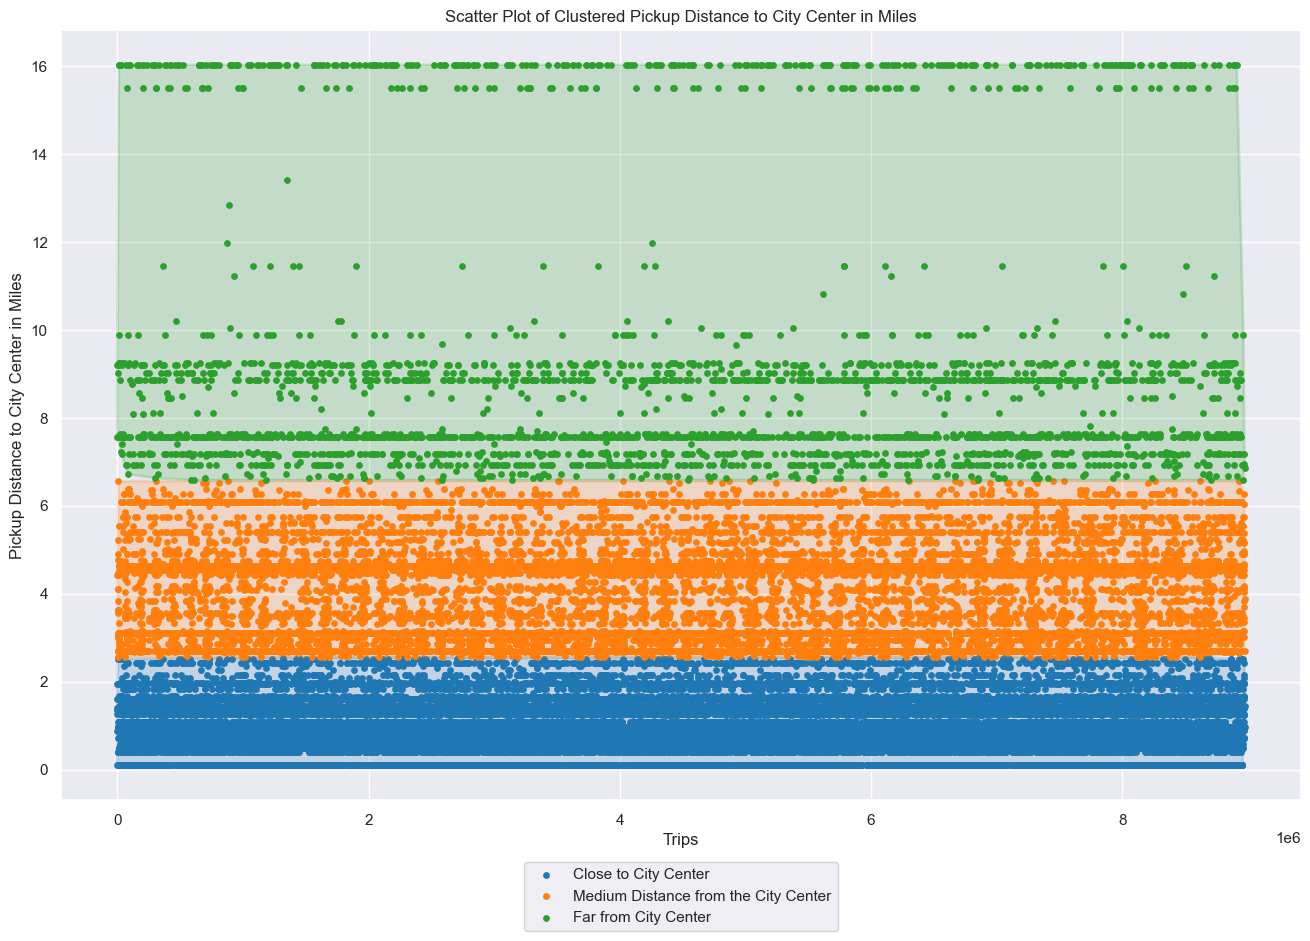

In [101]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_pickup_index.sample(n=50_000), x_col='Trip_Index', y_col='distance_to_city_center_pickup', cluster_col='cluster_number',
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Pickup Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Pickup Distance to City Center in Miles', leg_loc='lower center', anchor=(0.5, -0.18))

In [102]:
# insert map here?

### 1.6.1 Feature Selection - Distance to City Center Dropoff 

In [103]:
# Feature selection
dfChicago_clu_distance_to_city_center_dropoff = dfChicago_clustering[['distance_to_city_center_dropoff']]
dfChicago_clu_distance_to_city_center_dropoff

,distance_to_city_center_dropoff
0,1.387700
1,3.548918
2,6.577887
3,2.685629
4,0.587129
...,...
8974515,1.959038
8974516,4.414539
8974517,1.609951
8974518,2.141079


In [104]:
# Scaling the data
dfChicago_clu_distance_to_city_center_dropoff_scaled = scaling_data(dfChicago_clu_distance_to_city_center_dropoff)

### 1.6.2 Validation of Number of Clusters

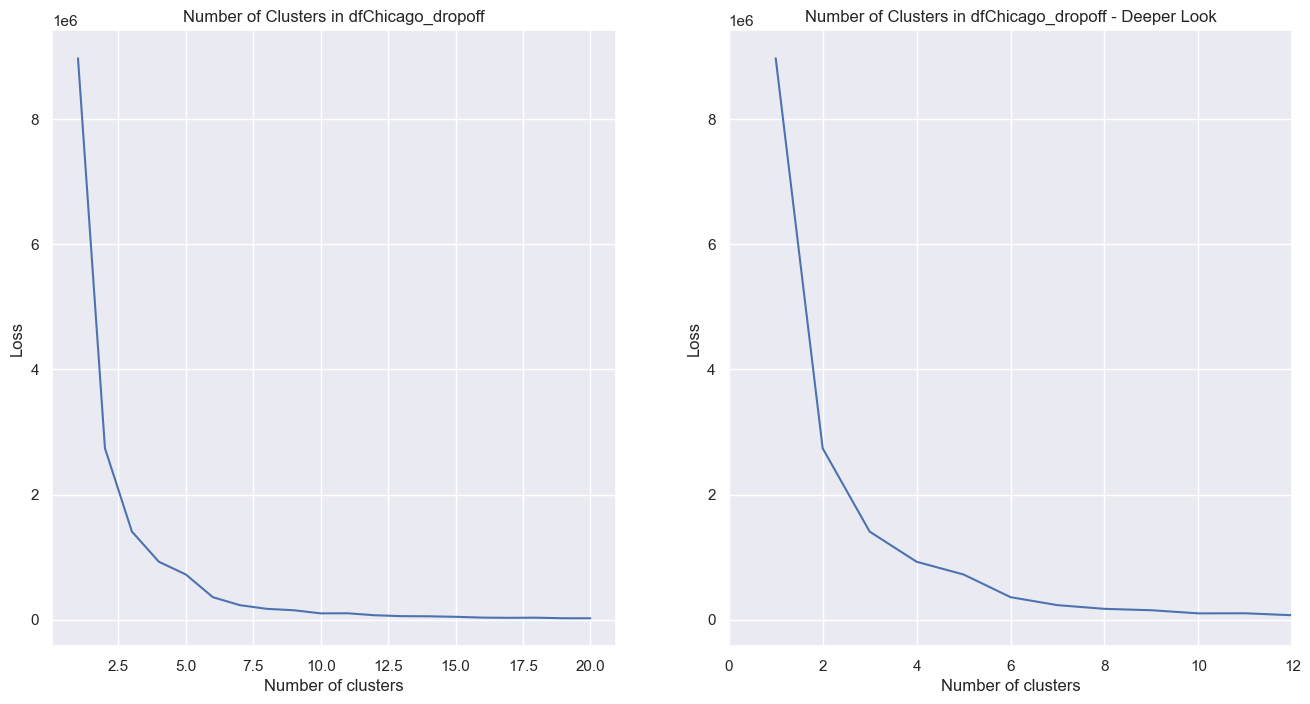

In [105]:
plot_best_fitting_number_of_clusters(dfChicago_clu_distance_to_city_center_dropoff_scaled, "in dfChicago_dropoff")

### 1.6.3 Computing Clusters with KMeans

In [106]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=3,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_distance_to_city_center_dropoff_scaled)

# creating a column for the calculated clusters
dfChicago_clu_distance_to_city_center_dropoff.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_distance_to_city_center_dropoff

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\200745104.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_dropoff.loc[:, 'cluster_number'] = Clusters


,distance_to_city_center_dropoff,cluster_number
0,1.387700,1
1,3.548918,0
2,6.577887,2
3,2.685629,0
4,0.587129,1
...,...,...
8974515,1.959038,1
8974516,4.414539,0
8974517,1.609951,1
8974518,2.141079,1


### 1.6.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


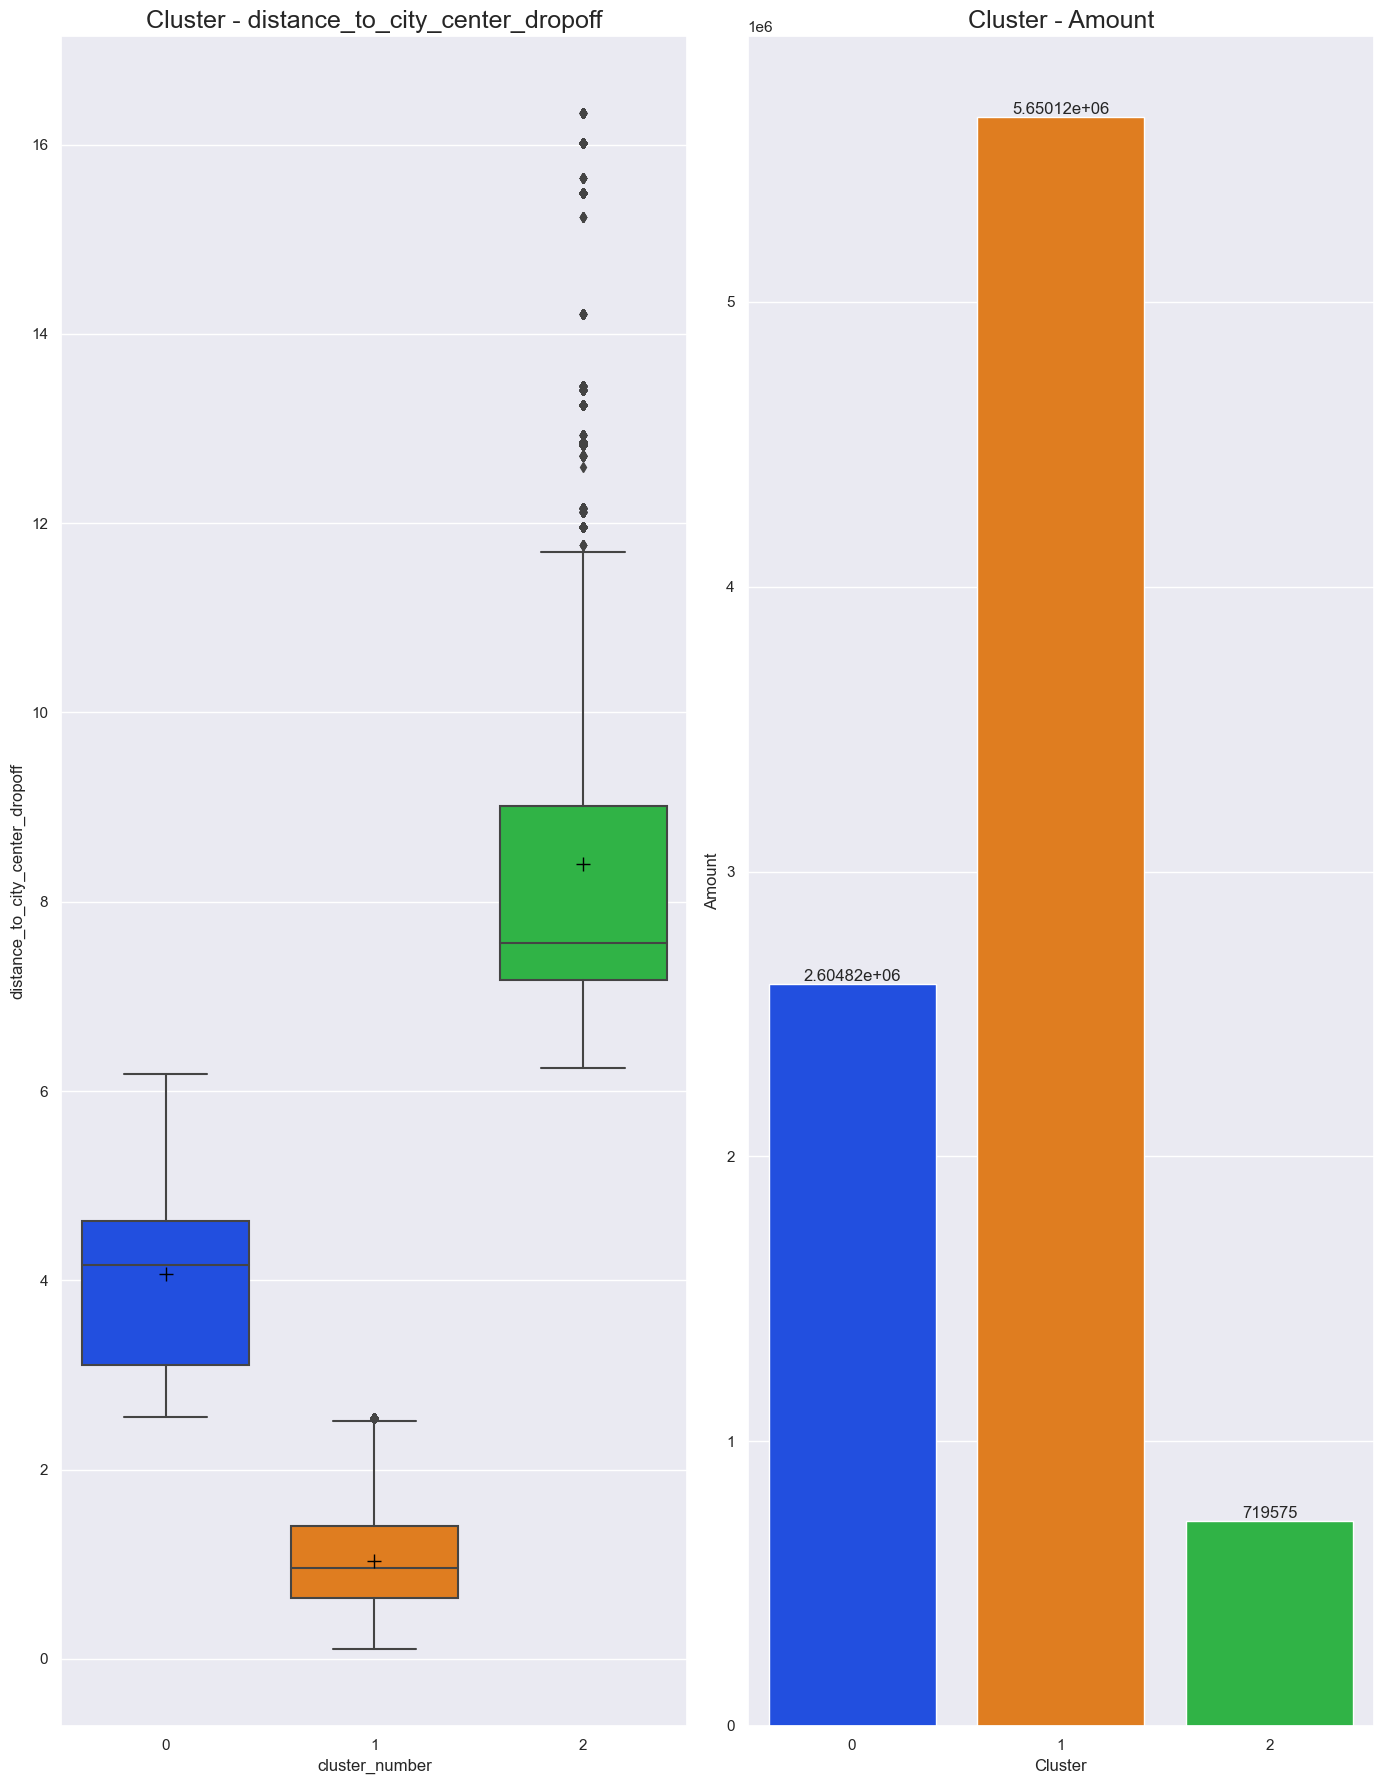

In [107]:
plot_information_about_clusters(dfChicago_clu_distance_to_city_center_dropoff, ['distance_to_city_center_dropoff'], 'cluster_number')

In [109]:
dfChicago_clu_distance_to_city_center_dropoff_quantiles = get_quantiles_of_clusters(dfChicago_clu_distance_to_city_center_dropoff, 3, 'cluster_number')
dfChicago_clu_distance_to_city_center_dropoff_quantiles.sort_values(by=['distance_to_city_center_dropoff'], ascending=False)

,distance_to_city_center_dropoff,Amount Trips in Cluster,Percentage
Cluster,,,
2,7.18 - 9.01,719575.0,8.02
0,3.1 - 4.62,2604822.0,29.02
1,0.64 - 1.4,5650123.0,62.96


In [110]:
label_names = {'0': "Medium Distance from the City Center", 
               '1': "Close to City Center",
               '2': "Far from City Center "
               }

# integrating our labeled clusters in the dataframe
dfChicago_clu_distance_to_city_center_dropoff['Cluster_Label'] = dfChicago_clu_distance_to_city_center_dropoff['cluster_number'].astype(str)
dfChicago_clu_distance_to_city_center_dropoff = dfChicago_clu_distance_to_city_center_dropoff.replace({"Cluster_Label": label_names})

dfChicago_clu_distance_to_city_center_dropoff_index = dfChicago_clu_distance_to_city_center_dropoff
dfChicago_clu_distance_to_city_center_dropoff_index['Trip_Index'] = dfChicago_clu_distance_to_city_center_dropoff_index.index
dfChicago_clu_distance_to_city_center_dropoff_index

C:\Users\jonas\AppData\Local\Temp\ipykernel_21624\4125057298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_distance_to_city_center_dropoff['Cluster_Label'] = dfChicago_clu_distance_to_city_center_dropoff['cluster_number'].astype(str)


,distance_to_city_center_dropoff,cluster_number,Cluster_Label,Trip_Index
0,1.387700,1,Close to City Center,0
1,3.548918,0,Medium Distance from the City Center,1
2,6.577887,2,Far from City Center,2
3,2.685629,0,Medium Distance from the City Center,3
4,0.587129,1,Close to City Center,4
...,...,...,...,...
8974515,1.959038,1,Close to City Center,8974515
8974516,4.414539,0,Medium Distance from the City Center,8974516
8974517,1.609951,1,Close to City Center,8974517
8974518,2.141079,1,Close to City Center,8974518


### 1.6.5 Plotting the Clustering Results

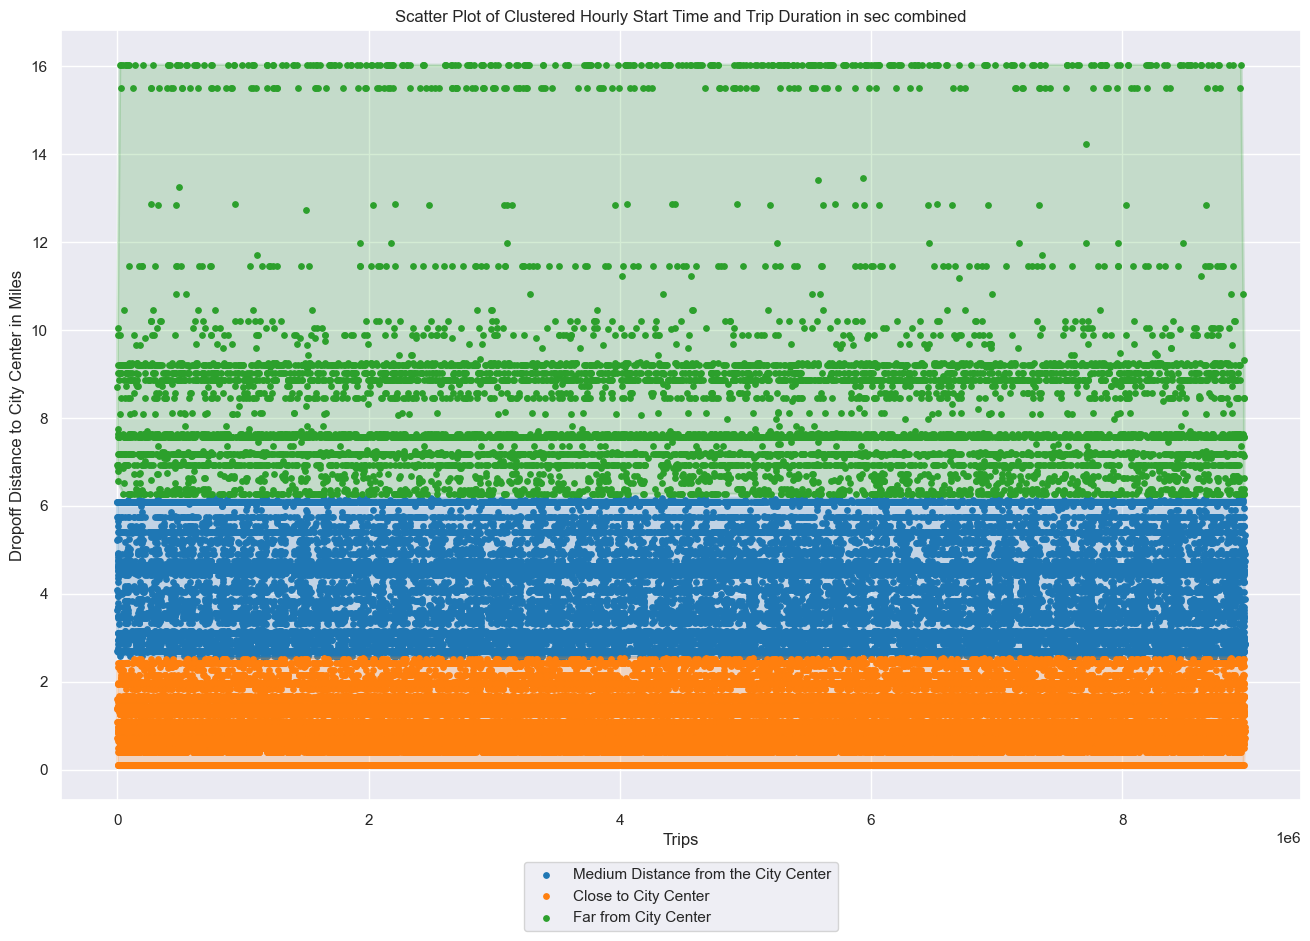

In [112]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_distance_to_city_center_dropoff.sample(n=100_000), x_col='Trip_Index', y_col='distance_to_city_center_dropoff', cluster_col='cluster_number', 
                        label_col="Cluster_Label", size_tuple=(16, 10), dp_size=15, x_label='Trips', y_label="Dropoff Distance to City Center in Miles", 
                        plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in sec combined', leg_loc='lower center', anchor=(0.5, -0.18))

In [113]:
#insert map?